## Install & import

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import seaborn as sns
import re
from scipy.stats import ttest_ind, f_oneway, zscore
from scipy.cluster.hierarchy import linkage
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.multitest import multipletests
from statsmodels.formula.api import ols
import statsmodels.api as sm
import adjustText as aT


## Load data

In [6]:
# Proteomics-Daten einlesen
proteomics_metadata = pd.read_csv("proteomics_with_metadata1.csv", index_col=0)
proteomics_without = pd.read_csv("proteomics_without_metadata1.csv", index_col=0)

#Kontrolle
print(proteomics_metadata.shape)
print(proteomics_without.shape)

C:\Users\Annaf\AppData\Local\Temp\ipykernel_3188\2161010886.py:2: DtypeWarning: Columns (3,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  proteomics_metadata = pd.read_csv("proteomics_with_metadata1.csv", index_col=0)


(144, 9138)
(149, 9126)


In [ ]:
meta_no_nans = proteomics_metadata.copy()

# IDs mit fehlendem tissue_type
missing_ids = meta_no_nans.index[meta_no_nans['tissue_type'].isna()]
print(" Entfernte Proben mit fehlendem tissue_type:")
print(missing_ids.tolist())

# Entfernen
meta_no_nans = meta_no_nans.drop(index=missing_ids)

❌ Entfernte Proben mit fehlendem tissue_type:
[]


In [8]:
# Entfernen der nicht benötigten Spalten
copy_og = proteomics_without.copy()
only_genes_df = copy_og.drop(columns=['Patient_ID', 'ParticipantID', 'TMT plex', 'TMT channel', 'batch_ID'])
print(len(only_genes_df.columns))

# --> group (Tumor / Normal) + 9120 Gene --> 9121 Spalten

9121


In [9]:
copycopy_og = proteomics_metadata.copy()
gen_tis = copycopy_og.drop(columns=[
    'ParticipantID (Case_ID)',
    #'Group',
    'age',
    'BMI',
    'tumor_stage_pathological',
    'tobacco_smoking_history',
    'diabetes',
    'histologic_type',
    'histologic_grade',
    'microsatellite_instability',
    'tumor_size_in_cm',
    'number_of_full_term_pregnancies',
    'pathologic_staging_primary_tumor_pT',
    'ParticipantID',
    'TMT plex',
    'TMT channel',
    'batch_ID',
    #'tissue_type',
    ]) 

print(len(gen_tis.columns)) #es sollte 9122 rauskommen

9122


#[x for x in meta_no_nans]
 alle Spalten die keine Gene sind:
"""
['ParticipantID (Case_ID)',
 'Group',
 'age',
 'BMI',
 'tumor_stage_pathological',
 'tobacco_smoking_history',
 'diabetes',
 'histologic_type',
 'histologic_grade',
 'microsatellite_instability',
 'tumor_size_in_cm',
 'number_of_full_term_pregnancies',
 'pathologic_staging_primary_tumor_pT',
 'ParticipantID',
 'TMT plex',
 'TMT channel',
 'batch_ID',
 'tissue_type']
""""

## Histograms & count plot of meta data

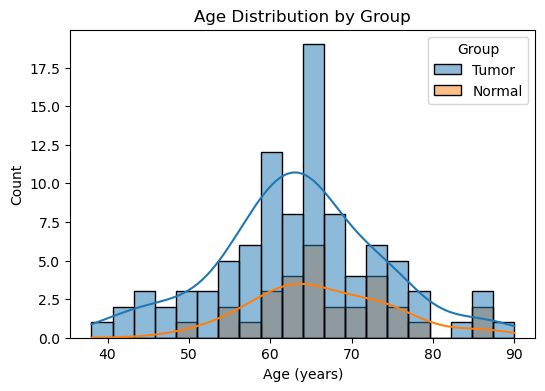

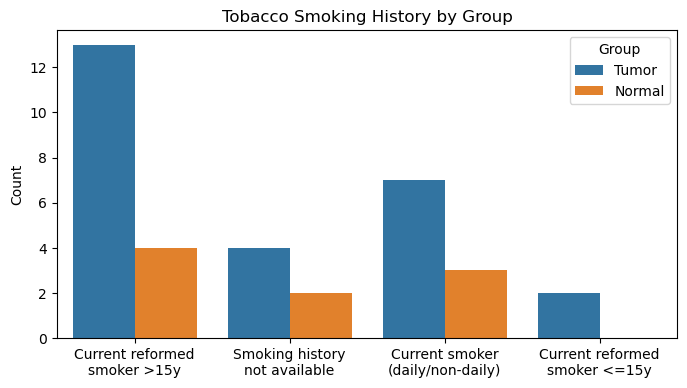

In [10]:
# Alter
proteomics_metadata['age'] = proteomics_metadata['age'].replace('>=90', 90)
proteomics_metadata['age'] = pd.to_numeric(proteomics_metadata['age'], errors='coerce')

plt.figure(figsize=(6,4))
sns.histplot(proteomics_metadata.dropna(subset=['age']), x='age', hue='Group', kde=True, bins=20)
plt.title('Age Distribution by Group')
plt.xlabel('Age (years)')
plt.ylabel('Count')
plt.show()

# Tobacco Smoking History
# # Mapping der langen Labels auf umgebrochene Versionen
tobacco_map = {
    "lifelong non-smoker: Less than 100 cigarettes smoked in lifetime": "lifelong\nnon-smoker",
    "Current reformed smoker, more than 15 years": "Current reformed\nsmoker >15y",
    "Smoking history not available": "Smoking history\nnot available",
    "Current smoker: Includes daily and non-daily smokers": "Current smoker\n(daily/non-daily)",
    "Current reformed smoker within past 15 years": "Current reformed\nsmoker <=15y"
}

proteomics_metadata['tobacco_smoking_history_wrapped'] = proteomics_metadata['tobacco_smoking_history'].map(tobacco_map)

plt.figure(figsize=(8,4))
sns.countplot(data=proteomics_metadata, x='tobacco_smoking_history_wrapped', hue='Group')
plt.title('Tobacco Smoking History by Group')
plt.xlabel('')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Labels sind jetzt kurz genug
plt.show()

## PCA

In [11]:
counts = proteomics_metadata['tissue_type'].value_counts()
print(counts)

tissue_type
Endometrioid carcinoma    83
Normal                    49
Serous carcinoma          12
Name: count, dtype: int64


### subplot legende final

C:\Users\Annaf\AppData\Local\Temp\ipykernel_3188\2733482659.py:94: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pca_var_df, x='PC', y='Explained Variance (%)', palette='Blues_d', ax=axes[3])


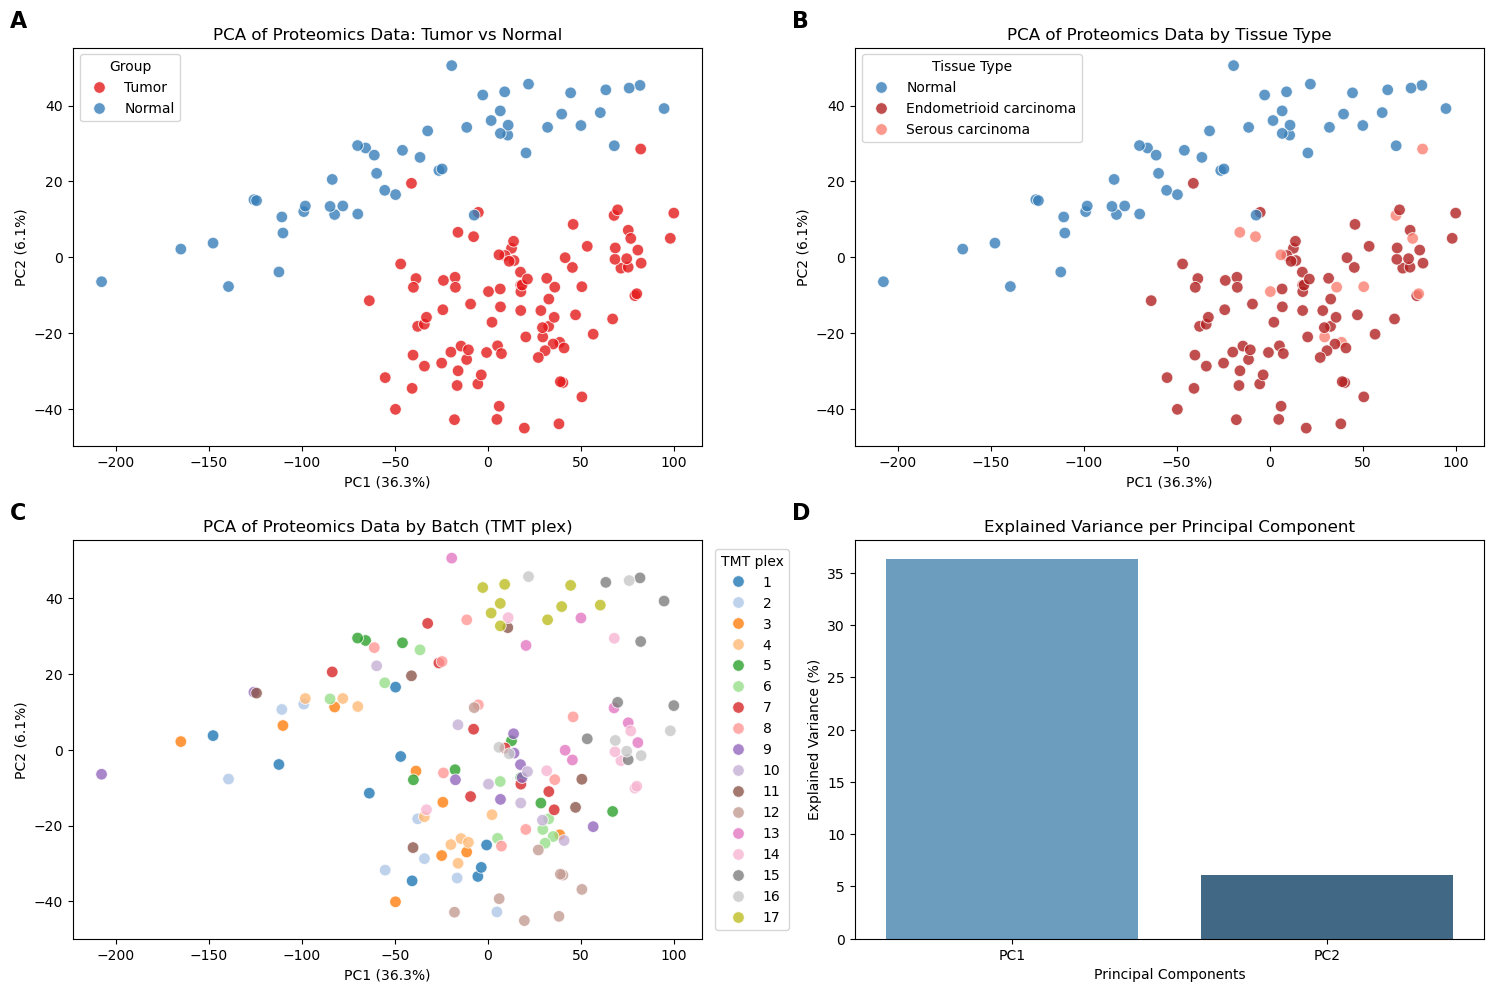

In [12]:

meta_cols = [
    'Patient_ID', 'ParticipantID', 'Group', 'TMT channel', 'TMT plex',
    'age', 'gender', 'BMI', 'tumor_stage_pathological',
    'tobacco_smoking_history', 'diabetes',
    'histologic_type', 'histologic_grade', 'microsatellite_instability', 'tissue_type'
]

existing_meta_cols = [c for c in meta_cols if c in proteomics_metadata.columns]
meta = proteomics_metadata[existing_meta_cols].copy()
expr = proteomics_metadata.drop(columns=existing_meta_cols, errors="ignore")
expr = expr.select_dtypes(include=[np.number])
expr_filled = expr.fillna(expr.mean(axis=0))

# PCA vorbereiten
scaler = StandardScaler()
expr_scaled = scaler.fit_transform(expr_filled)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(expr_scaled)

pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'], index=meta.index)
for col in ['Group', 'tissue_type', 'TMT plex', 'tumor_stage_pathological']:
    if col in meta.columns:
        pca_df[col] = meta[col].values

# ------------------------------------------------------
# Layout für Subplots (2 Reihen, 3 Spalten → letzte leer)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

# Buchstaben für Subplots
labels = ['A', 'B', 'C', 'D']

# ------------------------------------------------------
# A: PCA nach Group

sns.scatterplot(
    data=pca_df, x='PC1', y='PC2', hue='Group', palette='Set1', s=70, alpha=0.8, ax=axes[0]
)
axes[0].set_title('PCA of Proteomics Data: Tumor vs Normal')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
axes[0].legend(title='Group', loc='best')
axes[0].text(-0.1, 1.05, 'A', transform=axes[0].transAxes, fontsize=16, fontweight='bold')

# ------------------------------------------------------
# B: PCA nach Tissue Type

tissue_colors = {'Normal': '#377eb8', 'Endometrioid carcinoma': 'firebrick', 'Serous carcinoma': 'salmon'}
tissue_order = ['Normal', 'Endometrioid carcinoma', 'Serous carcinoma']

sns.scatterplot(
    data=pca_df, x='PC1', y='PC2', hue='tissue_type',
    hue_order=tissue_order, palette=tissue_colors, s=70, alpha=0.8, ax=axes[1]
)
axes[1].set_title('PCA of Proteomics Data by Tissue Type')
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
axes[1].legend(title='Tissue Type', loc='best')
axes[1].text(-0.1, 1.05, 'B', transform=axes[1].transAxes, fontsize=16, fontweight='bold')


# ------------------------------------------------------
# C: PCA nach Batch / TMT plex

sns.scatterplot(
    data=pca_df, x='PC1', y='PC2', hue='TMT plex', palette='tab20', s=70, alpha=0.8, ax=axes[2]
)
axes[2].set_title('PCA of Proteomics Data by Batch (TMT plex)')
axes[2].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
axes[2].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
axes[2].text(-0.1, 1.05, 'C', transform=axes[2].transAxes, fontsize=16, fontweight='bold')
# Legende außerhalb rechts neben dem Plot
leg = axes[2].legend(
    title='TMT plex',
    bbox_to_anchor=(1.02, 0.5),   # X=1.02: leicht außerhalb; Y=0.5: vertikal zentriert
    loc='center left',
    borderaxespad=0,
    frameon=True
)

# optional: Schriftgröße etwas kleiner
for text in leg.get_texts():
    text.set_fontsize(10)

# ------------------------------------------------------
# D: Varianzanteil der PCs

n_components = len(pca.explained_variance_ratio_)
pca_var_df = pd.DataFrame({
    'PC': [f'PC{i+1}' for i in range(n_components)],
    'Explained Variance (%)': pca.explained_variance_ratio_ * 100
})
sns.barplot(data=pca_var_df, x='PC', y='Explained Variance (%)', palette='Blues_d', ax=axes[3])
axes[3].set_title('Explained Variance per Principal Component')
axes[3].set_xlabel('Principal Components')
axes[3].set_ylabel('Explained Variance (%)')
axes[3].text(-0.1, 1.05, 'D', transform=axes[3].transAxes, fontsize=16, fontweight='bold')


plt.tight_layout()
plt.show()


# Clustering
FDR , T test, Tumor vs Normal, endometrioid vs serous carcinoma

Anzahl der Spalten für Tumor vs Normal: 9120


c:\Users\Annaf\anaconda3\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\Annaf\anaconda3\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


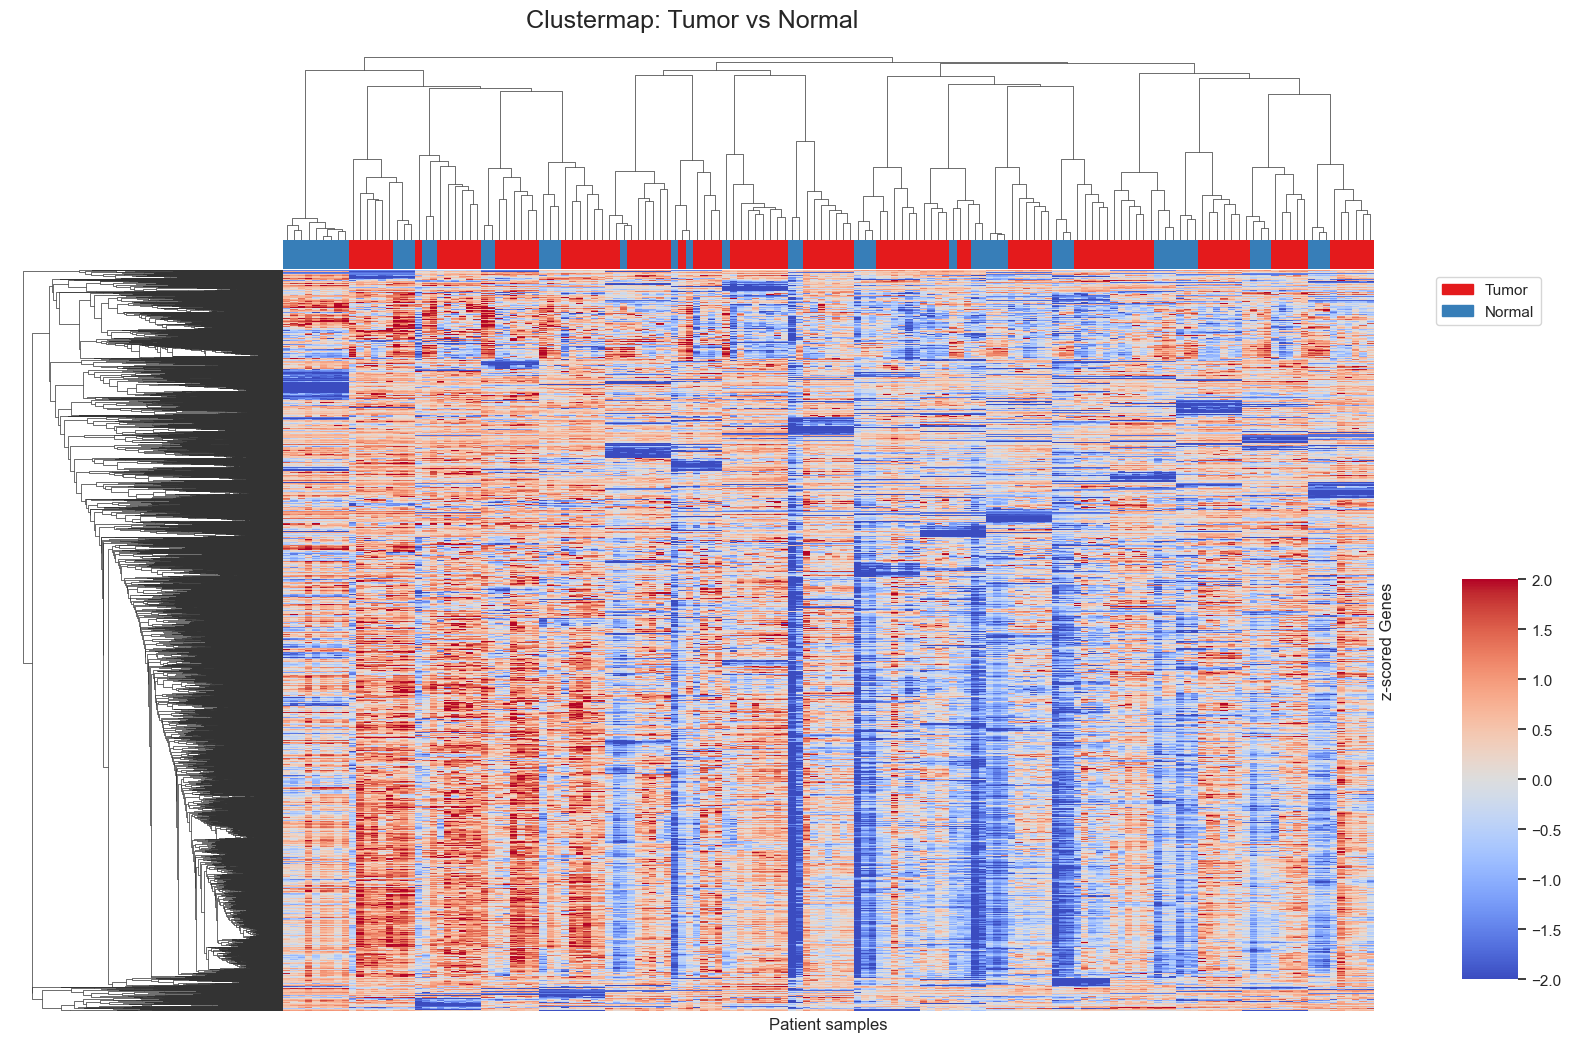

Anzahl der Spalten für Endometrioid vs Serous Tumors: 9120


c:\Users\Annaf\anaconda3\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\Annaf\anaconda3\Lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


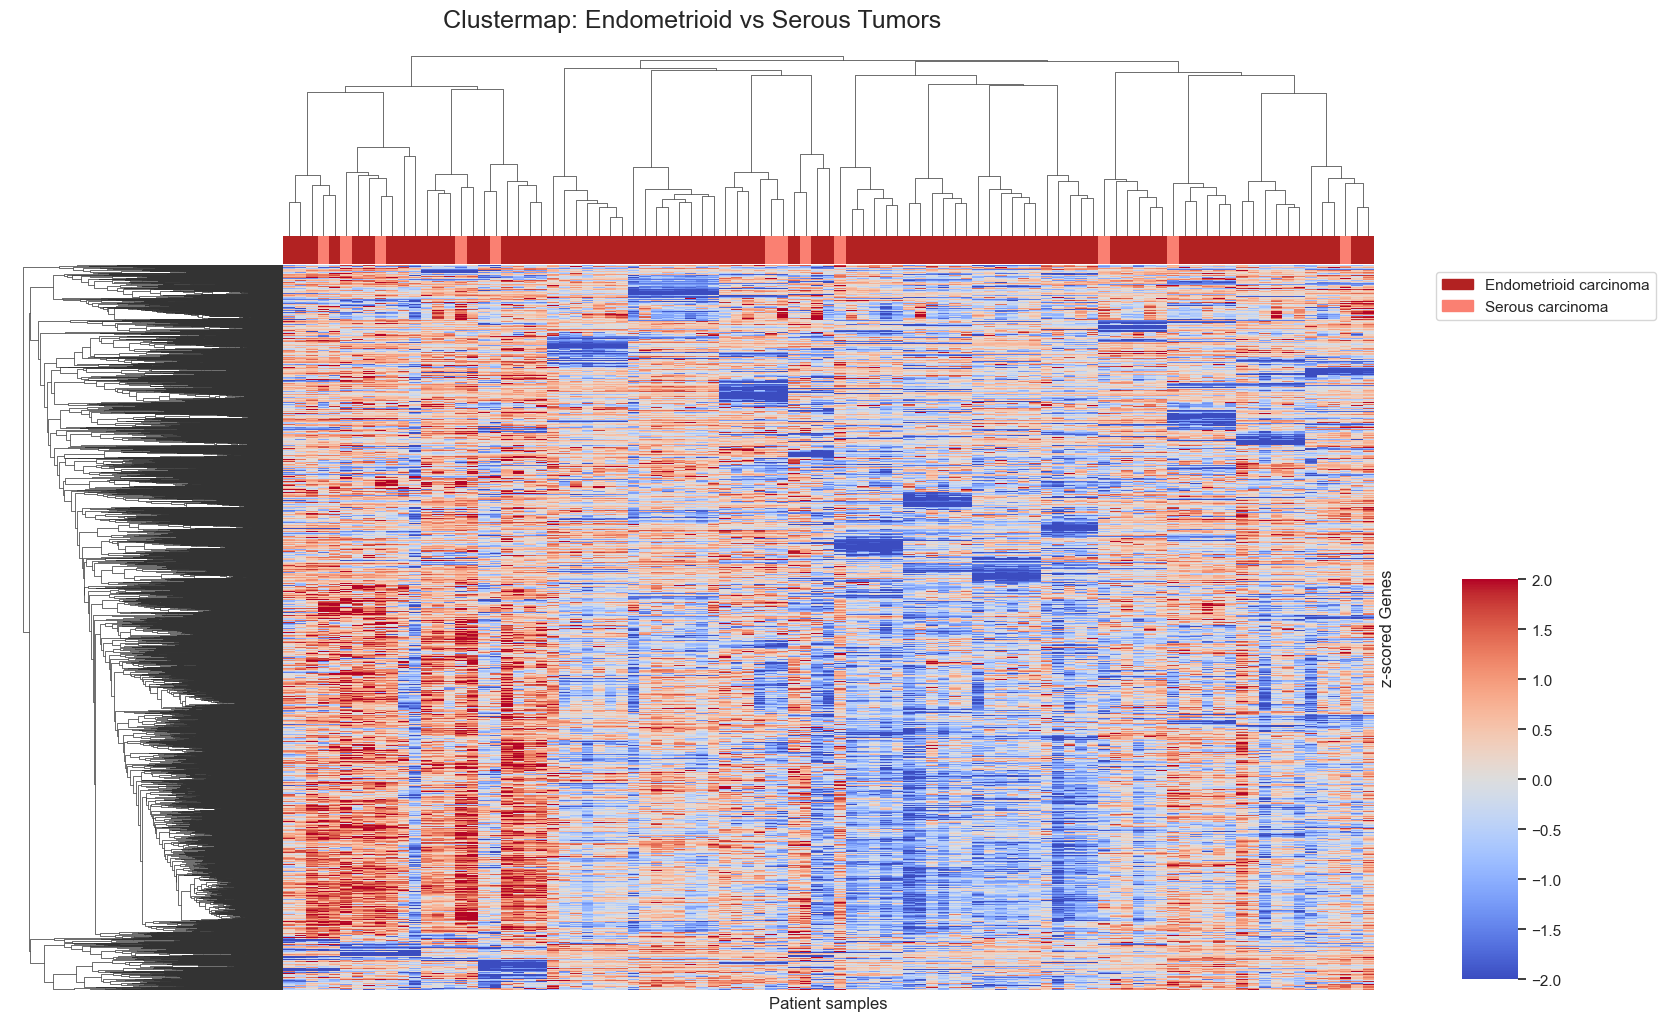

In [13]:
# ------------------------------------------------------
# Tumor vs Normal

expr_all = only_genes_df.drop(columns=['Group'])  # nur Gene
print("Anzahl der Spalten für Tumor vs Normal:", expr_all.shape[1])  # Anzahl Gene
expr_all = expr_all.fillna(expr_all.mean(axis=0))
expr_z_all = expr_all.apply(lambda col: zscore(col, nan_policy='omit'), axis=0).fillna(0)
data_clustermap_all = expr_z_all.T

col_colors_all = only_genes_df['Group'].str.strip().map({'Tumor':'#e41a1c','Normal':'#377eb8'}).fillna('lightgrey')

sns.set(style="white")
g1 = sns.clustermap(
    data_clustermap_all,
    col_colors=list(col_colors_all),
    cmap='coolwarm',
    figsize=(14,10),
    xticklabels=False,
    yticklabels=False,
    metric='correlation',
    method='average',
    vmin=-2, vmax=2
)

tumor_patch = mpatches.Patch(color='#e41a1c', label='Tumor')
normal_patch = mpatches.Patch(color='#377eb8', label='Normal')
g1.ax_heatmap.legend(handles=[tumor_patch, normal_patch], loc='upper left', bbox_to_anchor=(1.05, 1))

g1.ax_heatmap.set_xlabel("Patient samples")
g1.ax_heatmap.set_ylabel("z-scored Genes")
plt.suptitle("Clustermap: Tumor vs Normal", y=1.02, fontsize=18)
g1.cax.set_position([1.05, 0.05, 0.04, 0.4])
plt.show()

# ------------------------------------------------------
# Endometrioid vs Serous (nur Tumor)

# Nur Tumor-Samples filtern
meta_tumor = gen_tis[(gen_tis['Group']=='Tumor') & (gen_tis['tissue_type'].isin(['Endometrioid carcinoma', 'Serous carcinoma']))].copy()

expr_tumor = meta_tumor.drop(columns=['Group','tissue_type']).fillna(meta_tumor.drop(columns=['Group','tissue_type']).mean(axis=0))
print("Anzahl der Spalten für Endometrioid vs Serous Tumors:", expr_tumor.shape[1])  # Anzahl Gene
expr_tumor_z = expr_tumor.apply(lambda col: zscore(col, nan_policy='omit'), axis=0).fillna(0)
data_clustermap_tumor = expr_tumor_z.T

col_colors_tumor = meta_tumor['tissue_type'].map({'Endometrioid carcinoma':'firebrick','Serous carcinoma':'salmon'}).fillna('lightgrey')

g2 = sns.clustermap(
    data_clustermap_tumor,
    col_colors=list(col_colors_tumor),
    cmap='coolwarm',
    figsize=(14,10),
    xticklabels=False,
    yticklabels=False,
    metric='correlation',
    method='average',
    vmin=-2, vmax=2
)

endometrioid_patch = mpatches.Patch(color='firebrick', label='Endometrioid carcinoma')
serous_patch = mpatches.Patch(color='salmon', label='Serous carcinoma')
g2.ax_heatmap.legend(handles=[endometrioid_patch, serous_patch], loc='upper left', bbox_to_anchor=(1.05, 1))

g2.ax_heatmap.set_xlabel("Patient samples")
g2.ax_heatmap.set_ylabel("z-scored Genes")
plt.suptitle("Clustermap: Endometrioid vs Serous Tumors", y=1.02, fontsize=18)
g2.cax.set_position([1.05, 0.05, 0.04, 0.4])
plt.show()

# Volcano

Tumor vs Normal: 9120 Gene insgesamt → 9120 nach Varianzfilter > 0.05
Tumor vs Normal: 4909 signifikante Gene (FDR<0.05 + |log2FC|>0.5)
Top 15 signifikanteste Gene: ['AMACR', 'IL18', 'IL4I1', 'S100A9', 'BAIAP2L1', 'SMPDL3B', 'OGN', 'S100A8', 'RAB25', 'STXBP6', 'KANK2', 'RDH10', 'TRAF4', 'EPPK1', 'GFPT1']


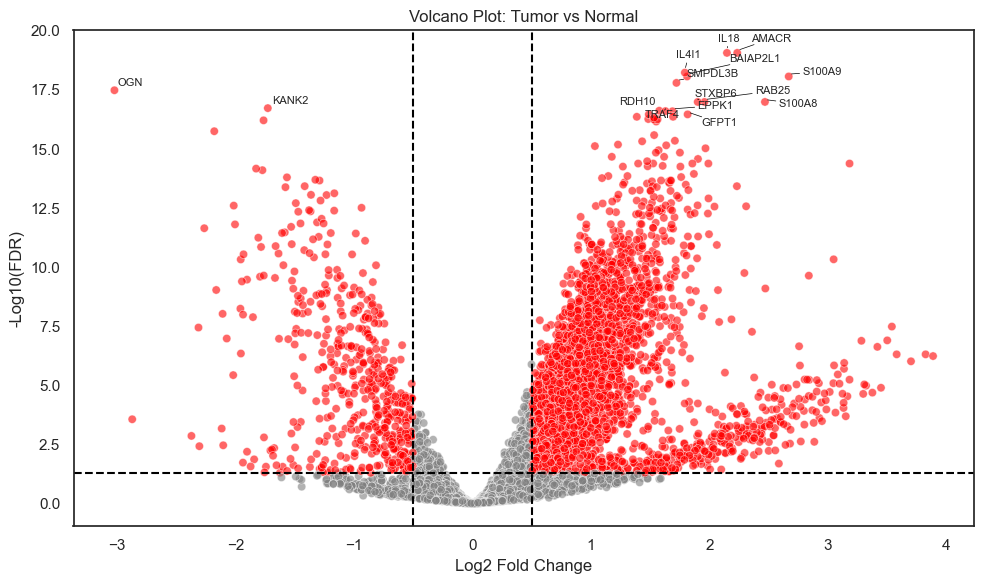

Endometrioid vs Serous: 9120 Gene insgesamt → 9120 nach Varianzfilter > 0.05
Endometrioid vs Serous: 300 signifikante Gene (FDR<0.05 + |log2FC|>0.5)
Top 15 signifikanteste Gene: ['SENP2', 'MUC5B', 'DLGAP5', 'CCNB1', 'TWIST1', 'NIFK', 'TWIST2', 'GALNT4', 'GLS', 'NDC80', 'WDR75', 'CPNE8', 'ST6GALNAC1', 'MCM7', 'MX2']


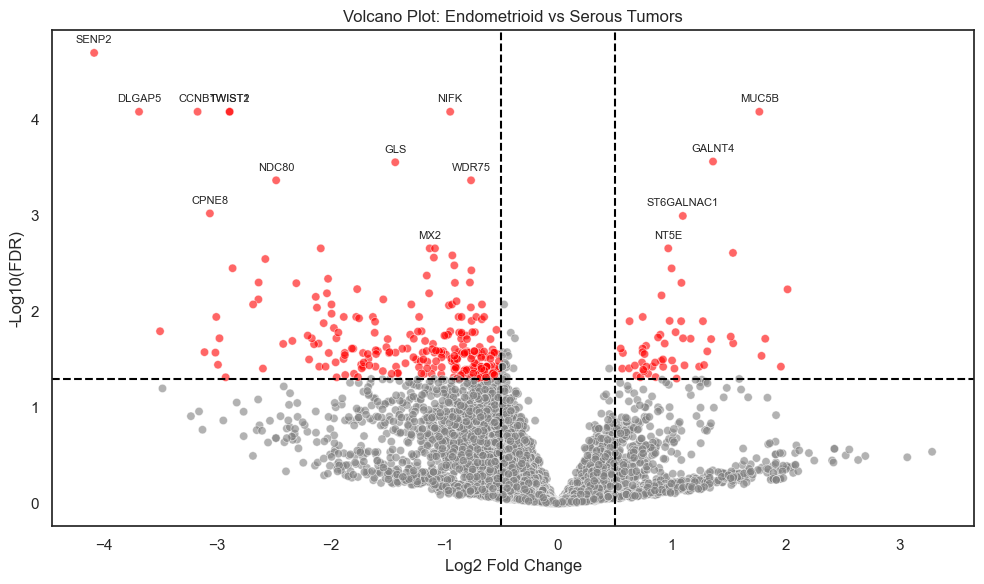

In [14]:
var_threshold = 0.05  # Varianzfilter
p_thresh = 0.05       # FDR-Schwelle
fc_thresh = 0.5       # Fold-change Schwelle (log2)
top_n = 15
sns.set(style="white")

# ------------------------------------------------------
# Tumor vs Normal

meta = only_genes_df[['Group']].copy()
expr = only_genes_df.drop(columns=['Group']).select_dtypes(include=np.number)
expr = expr.fillna(expr.mean(axis=0))

# Varianzfilter
gene_mask = expr.var(axis=0) > var_threshold
expr_filtered = expr.loc[:, gene_mask]
print(f"Tumor vs Normal: {expr.shape[1]} Gene insgesamt → {expr_filtered.shape[1]} nach Varianzfilter > {var_threshold}")

tumor_samples = meta.index[meta['Group'].str.strip()=='Tumor']
normal_samples = meta.index[meta['Group'].str.strip()=='Normal']

# t-Test pro Gen
t_stats, p_vals = [], []
for gene in expr_filtered.columns:
    t_stat, p_val = ttest_ind(
        expr_filtered.loc[tumor_samples, gene],
        expr_filtered.loc[normal_samples, gene],
        equal_var=False,
        nan_policy='omit'
    )
    t_stats.append(t_stat)
    p_vals.append(p_val)

log2FC = expr_filtered.loc[tumor_samples].mean() - expr_filtered.loc[normal_samples].mean()

results_tn = pd.DataFrame({
    'Gene': expr_filtered.columns,
    't_stat': t_stats,
    'p_value': p_vals,
    'log2FC': log2FC.values
})
results_tn['p_adj'] = multipletests(results_tn['p_value'], method='fdr_bh')[1]
results_tn['Significant'] = (results_tn['p_adj'] < p_thresh) & (results_tn['log2FC'].abs() > fc_thresh)

print(f"Tumor vs Normal: {results_tn['Significant'].sum()} signifikante Gene (FDR<{p_thresh} + |log2FC|>{fc_thresh})")
sig_tn_genes = results_tn.loc[results_tn['Significant'], 'Gene'].tolist()
print("Top 15 signifikanteste Gene:", results_tn.sort_values('p_adj').head(top_n)['Gene'].tolist())

# Volcano Plot
results_tn['neg_log10_FDR'] = -np.log10(results_tn['p_adj'].replace(0,1e-300))
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=results_tn,
    x='log2FC',
    y='neg_log10_FDR',
    hue='Significant',
    palette={True:'red', False:'grey'},
    alpha=0.6,
    edgecolor='white',
    legend=False
)
plt.axhline(-np.log10(p_thresh), linestyle='--', color='black')
plt.axvline(fc_thresh, linestyle='--', color='black')
plt.axvline(-fc_thresh, linestyle='--', color='black')
plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10(FDR)")
plt.title("Volcano Plot: Tumor vs Normal")
#plt.legend(title="Significant")

# Top 15 Gene annotieren
annotate_df = results_tn.nsmallest(top_n, 'p_adj')
texts = []
for _, row in annotate_df.iterrows():
    texts.append(plt.text(row['log2FC'], row['neg_log10_FDR']+0.1, row['Gene'], fontsize=8))
aT.adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', lw=0.5))
plt.tight_layout()
plt.show()


# ------------------------------------------------------
# Endometrioid vs Serous Tumor

meta_tumor = gen_tis[(gen_tis['Group']=='Tumor') & (gen_tis['tissue_type'].isin(['Endometrioid carcinoma','Serous carcinoma']))]
expr_tumor = meta_tumor.drop(columns=['Group','tissue_type']).select_dtypes(include=np.number)
expr_tumor = expr_tumor.fillna(expr_tumor.mean(axis=0))

# Varianzfilter
gene_mask_tumor = expr_tumor.var(axis=0) > var_threshold
expr_tumor_filtered = expr_tumor.loc[:, gene_mask_tumor]
print(f"Endometrioid vs Serous: {expr_tumor.shape[1]} Gene insgesamt → {expr_tumor_filtered.shape[1]} nach Varianzfilter > {var_threshold}")

tumor1_samples = meta_tumor.index[meta_tumor['tissue_type']=='Endometrioid carcinoma']
tumor2_samples = meta_tumor.index[meta_tumor['tissue_type']=='Serous carcinoma']

t_stats, p_vals = [], []
for gene in expr_tumor_filtered.columns:
    t_stat, p_val = ttest_ind(
        expr_tumor_filtered.loc[tumor1_samples, gene],
        expr_tumor_filtered.loc[tumor2_samples, gene],
        equal_var=False,
        nan_policy='omit'
    )
    t_stats.append(t_stat)
    p_vals.append(p_val)

log2FC = expr_tumor_filtered.loc[tumor1_samples].mean() - expr_tumor_filtered.loc[tumor2_samples].mean()

results_tumor = pd.DataFrame({
    'Gene': expr_tumor_filtered.columns,
    't_stat': t_stats,
    'p_value': p_vals,
    'log2FC': log2FC.values
})
results_tumor['p_adj'] = multipletests(results_tumor['p_value'], method='fdr_bh')[1]
results_tumor['Significant'] = (results_tumor['p_adj'] < p_thresh) & (results_tumor['log2FC'].abs() > fc_thresh)

print(f"Endometrioid vs Serous: {results_tumor['Significant'].sum()} signifikante Gene (FDR<{p_thresh} + |log2FC|>{fc_thresh})")
sig_tumor_genes = results_tumor.loc[results_tumor['Significant'], 'Gene'].tolist()
print("Top 15 signifikanteste Gene:", results_tumor.sort_values('p_adj').head(top_n)['Gene'].tolist())

# Volcano Plot
results_tumor['neg_log10_FDR'] = -np.log10(results_tumor['p_adj'].replace(0,1e-300))
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=results_tumor,
    x='log2FC',
    y='neg_log10_FDR',
    hue='Significant',
    palette={True:'red', False:'grey'},
    alpha=0.6,
    edgecolor='white',
    legend=False
)
plt.axhline(-np.log10(p_thresh), linestyle='--', color='black')
plt.axvline(fc_thresh, linestyle='--', color='black')
plt.axvline(-fc_thresh, linestyle='--', color='black')
plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10(FDR)")
plt.title("Volcano Plot: Endometrioid vs Serous Tumors")
#plt.legend(title="Significant")

# Top 15 Gene annotieren
annotate_df = results_tumor.nsmallest(top_n, 'p_adj')
for _, row in annotate_df.iterrows():
    plt.text(row['log2FC'], row['neg_log10_FDR']+0.1, row['Gene'], fontsize=8, ha='center')
plt.tight_layout()
plt.show()

# t-test from volcano for gprofiler: significant genes tumor vs normal, endometrioid vs serous

In [15]:
# TUMOR VS NORMAL --> 4909 signifikante Gene

sig_tn_string = " ".join(sig_tn_genes)
#print("Anzahl signifikante Gene (Liste):", len(sig_tn_genes))   # <-- sollte 4909 ausgeben
print(sig_tn_string)
# Verifiziere, dass der String genau so viele Einträge enthält wie die Liste
#print("Anzahl Gene im String (split):", len(sig_tn_string.split()))  # <-- sollte ebenfalls 4909

MUT DHX32 RFX5 EIF3K ARCN1 KDM3B UBA5 TAOK1 PSMD8 PRRC2A ERMP1 GSS CCT5 EPM2AIP1 NES ENOSF1 IDH2 RSRC2 PARS2 MARCKSL1 RFX3 TRMT1L MFF NEDD4 ATG9A PLA2G4A ALDH1A3 IREB2 QARS NANS SETX MAMDC2 UQCRFS1 UQCRFS1P1 EFTUD1 ZC3HAV1 RUVBL2 DKK4 CLPB LARP4 MCM2 ACADVL YLPM1 TMED10 RBM25 NUMB LSG1 INTS8 UNC13D SUDS3 NAT10 RANBP2 USP43 RAPH1 NDUFV1 KLC2 EIF3M TUFM DHX30 LMAN1 ASRGL1 NASP FASN DNAJB11 DHPS CCT3 TRMT10C MTSS1L DDX46 MARK2 SND1 AARS CARS NOL8 PPM1F RPS5 YTHDF3 TOMM22 PRKCI TMPO STAT1 FILIP1 SKIV2L2 ARHGAP25 HUWE1 IARS TECPR1 RBBP6 SPAST APBB1IP IRF2BP2 PODN LRPPRC ABI3BP GARS CCDC186 PLAA NUDC RUVBL1 STAT3 PEX19 MDH2 RFC3 HADHA EIF2S3 EIF2S3L DDX21 EGLN1 GALNT7 MNDA CENPV EIF3L UBA7 NAA10 KDM5C CSK WAPAL WAS NOP2 VDAC2 NUFIP2 USP5 MYH14 MON2 MKI67 RANGAP1 RAI1 BAG6 NSF CDKN1B MAP2K3 POGZ MAVS TSFM BRAP HTT ECE1 KIF21A HEATR3 MCAM CRAT MATR3 MSH2 LIMS2 KDELC2 GPD2 SSR1 DHX29 SYK NAMPT AFM PSMC4 NT5C2 SEPHS1 USP34 ZC3H14 SARM1 USP24 COPB1 COPA CTSC LRWD1 PARP12 ATAD2 LARP1 RPAP3 SMTN BR

In [16]:
# g profiler custom background mit 9120 genen
background_genes = expr.columns.tolist()

#print(f"background_genes enthält {len(background_genes)} Gene.") --> es kommt 9120 raus

clean_background = []
for g in background_genes:
    if isinstance(g, str):
        g2 = g.strip()  # führende/trailing Whitespaces entfernen
        if g2.startswith("Unknown:"):  # unerwünschte Gene entfernen
            continue
        # interne Whitespaces zu Unterstrich ersetzen (optional, für sauberes split)
        g2 = "_".join(g2.split())
        if g2 != "":
            clean_background.append(g2)

# Kontrolle
#print("Anzahl Hintergrund-Gene nach Bereinigung:", len(clean_background))

# Erzeuge whitespace-separierten String
background_string_clean = " ".join(clean_background)
#print("Anzahl Gene im String (split):", len(background_string_clean.split()))

print(background_string_clean)


MUT DHX32 RFX5 EIF3K MICAL3 ARCN1 LSS GRHPR GCLC C14orf166 KDM3B UBA5 TAOK1 PSMD8 PRRC2A ERMP1 GSS CCT5 EPM2AIP1 NES ENOSF1 COPS6 CYFIP1 IDH2 RSRC2 CD97 PARS2 MARCKSL1 RFX3 TRMT1L ARMCX2 MFF GNPDA1 NEDD4 YAP1 UTRN IQGAP1 ATG9A NUP54 NRDE2 PLA2G4A TRAPPC11 CAPZA2 CAPZB ALDH1A3 IREB2 QARS CDYL NANS SETX MAMDC2 UQCRFS1 UQCRFS1P1 XDH EFTUD1 ZC3HAV1 RUVBL2 PREP ME1 PXN MEPCE ATP5J SCAF1 DKK4 CLPB LARP4 MCM2 THBS3 COMP ACADVL YLPM1 VPS41 TMED10 RBM25 NUMB LSG1 INTS8 UNC13D SUDS3 NAT10 NUP153 RANBP2 USP43 RAPH1 TSC2 NDUFV1 GSK3A GSK3B KLC2 CTCF UBA2 EIF3M TUFM ALDH9A1 DHX30 LMAN1 ASRGL1 NASP FASN FNTA DNAJB11 DHPS CCT3 TRMT10C ARRB1 ALDH7A1 MTSS1L MTMR6 DDX46 ZNF148 MARK2 SND1 SUPT6H PCYT1A AARS CARS NOL8 SARS PPM1F MAP1B C14orf159 RPS5 YTHDF3 EIF1 TOMM22 PRKCI TAF8 ACTR1B TMPO STAT1 STAT6 FILIP1 SKIV2L2 AKR1C3 ARHGAP25 HUWE1 IARS MTOR PI4KA EPS15 TECPR1 RBBP6 SPAST APBB1IP SDK1 HELZ IRF2BP2 PODN LRPPRC ABI3BP GARS CCDC186 PLAA PBX2 NUDC RUVBL1 MLH1 STAT3 USP8 PEX19 MDH2 PHLDB2 RFC3 HADHA EIF

In [17]:
# ENDOMETRIOID vs SEROUS tissue type --> 300 signifikante Gene
#print(len(sig_tumor_genes))

sig_endo_ser_string = " ".join(sig_tumor_genes)
print(sig_endo_ser_string)


PLA2G4A MAMDC2 MCM2 LSG1 SUDS3 ASRGL1 PCYT1A PRKCI TAF8 STAT1 DDX21 GALNT7 WAS NOP2 CRAT RPAP3 MSH6 KIF11 ADAR SLC12A2 SAP130 BAIAP2 KIAA1324 USP11 DNAJC10 WDR75 CTNNA2 MX2 SRM NT5E MCM4 MCM7 NOL11 PBLD PKHD1L1 PPFIBP1 MAN2A1 MAPK14 MYO9B DDX41 ALDH1L2 CPSF1 ACSL5 MDN1 TBL3 PDCD11 BMS1 HLTF DHX8 CHD4 PLCB4 NCAPD2 DHX36 GRB7 BLMH RAPGEF1 CAPS BOP1 HEATR1 RNF213 THEMIS2 ESF1 RIF1 NSFL1C WDR3 NOL6 DHX57 PPP1R18 CEBPZ PPP2R3A TRMT6 PAX8 AKAP8L PLEKHS1 PRKDC SENP3 NUCB2 FOXK1 ARHGAP4 DNTTIP2 PAM GATB IGF2BP3 MUC5B SMC4 NLRP2 SRGAP2 SMC2 AIP IFIT3 KIF13B GLS LTN1 LIG1 MEN1 KIF4A ARAP1 DDX18 ASUN TRIM47 PPP1R10 GFM1 SUPT16H TARS2 TBCB MED14 SMARCA5 ARID1A TACC3 PDZD8 TOP2A IGF2BP2 OGFR FBP1 HSPBP1 XPO5 MYO5C WDR36 UCHL1 CRYL1 TRIM2 TUBB6 COLGALT1 GOLM1 PRKCSH CPM AP1M2 B4GALT1 NOP58 PIGR NR3C1 ESR1 CTNNBL1 NUP205 AGR2 ABCF3 PGR ASNS MYBBP1A SSB JUN GCFC2 FAM49A TYMS MPST INPP4A FABP4 KPNA1 WDR12 DLGAP5 CIRH1A FAM3C PUM2 PLD3 CWC22 RSRC1 FAS ZGPAT BSPRY PELO CIB1 GALNT4 DIEXF DHRS7B RFC5 TPPP3

# ANOVA

### age (0 significant)

In [18]:
df = proteomics_metadata.copy()

# Altersangaben korrigieren
df['age'] = df['age'].replace({'>=90': 90, '≥90': 90})
df['age'] = pd.to_numeric(df['age'], errors='coerce')

# Altersgruppen definieren
bins = [0, 55, 70, np.inf]
labels = ['young', 'middle', 'old']
df['AgeGroup'] = pd.cut(df['age'], bins=bins, labels=labels, right=True)

# ------------------------------------------------------
# Expressionsspalten erkennen

meta_cols = [
    'ParticipantID (Case_ID)', 'Group', 'age', 'AgeGroup', 'BMI',
    'tumor_stage_pathological', 'tobacco_smoking_history',
    'diabetes', 'histologic_type', 'histologic_grade',
    'microsatellite_instability', 'tumor_size_in_cm',
    'number_of_full_term_pregnancies', 'pathologic_staging_primary_tumor_pT',
    'ParticipantID','TMT plex','TMT channel','batch_ID','tissue_type'
]

expr_cols = [c for c in df.select_dtypes(include=np.number).columns if c not in meta_cols]
print(f"Verwendete Gene für ANOVA: {len(expr_cols)}")

# ------------------------------------------------------
# Überblick über Gruppen

print("\n Gruppengrößen pro Tumor vs Normal & Altersgruppe:")
print(df.groupby(['Group', 'AgeGroup']).size().unstack(fill_value=0))

# ------------------------------------------------------
# ANOVA pro Gruppe (Tumor / Normal)

results = []

for grp in df['Group'].dropna().unique():
    sub = df[df['Group'].str.strip() == grp]
    print(f"\n------------------------------------------------------")
    print(f" ANOVA für Gruppe: {grp}")
    print(" ------------------------------------------------------")
    
    anova_res = []
    for gene in expr_cols:
        data = sub[['AgeGroup', gene]].dropna()
        if data['AgeGroup'].nunique() < 2:
            continue
        
        groups = [data.loc[data['AgeGroup']==g, gene].values for g in labels if g in data['AgeGroup'].values]
        
        # mindestens 2 Gruppen mit >1 Sample
        if len([g for g in groups if len(g) > 1]) < 2:
            continue
        
        f_stat, p_val = f_oneway(*groups)
        anova_res.append({'Gene': gene, 'F_stat': f_stat, 'p_value': p_val})
    
    anova_df = pd.DataFrame(anova_res)
    if anova_df.empty:
        print(" Keine Gene konnten ausgewertet werden.")
        continue
    
    # FDR-Korrektur
    anova_df['FDR'] = multipletests(anova_df['p_value'], method='fdr_bh')[1]
    sig_df = anova_df[anova_df['FDR'] < 0.05].sort_values('FDR')
    
    print(f"Gene insgesamt: {len(anova_df)}")
    print(f"Signifikant (FDR < 0.05): {len(sig_df)}")
    
    if not sig_df.empty:
        print("\nTop 10 signifikante Gene:")
        print(sig_df[['Gene','F_stat','FDR']].head(10).to_string(index=False))
    else:
        print("Keine signifikanten Gene gefunden.")
    
    results.append({'Group': grp, 'n_genes': len(anova_df), 'n_significant': len(sig_df)})

# ------------------------------------------------------
# Zusammenfassung

print("\n------------------------------------------------------")
print("Zusammenfassung: Alterseffekt auf Genexpression")
summary_df = pd.DataFrame(results)
print(summary_df.to_string(index=False))


Verwendete Gene für ANOVA: 9120

 Gruppengrößen pro Tumor vs Normal & Altersgruppe:
AgeGroup  young  middle  old
Group                       
Normal        2      17   11
Tumor        15      59   21

------------------------------------------------------
 ANOVA für Gruppe: Tumor
 ------------------------------------------------------


C:\Users\Annaf\AppData\Local\Temp\ipykernel_3188\1077753870.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby(['Group', 'AgeGroup']).size().unstack(fill_value=0))


Gene insgesamt: 9120
Signifikant (FDR < 0.05): 0
Keine signifikanten Gene gefunden.

------------------------------------------------------
 ANOVA für Gruppe: Normal
 ------------------------------------------------------
Gene insgesamt: 9120
Signifikant (FDR < 0.05): 0
Keine signifikanten Gene gefunden.

------------------------------------------------------
Zusammenfassung: Alterseffekt auf Genexpression
 Group  n_genes  n_significant
 Tumor     9120              0
Normal     9120              0


### diabetes (0 significant)

In [21]:
# ------------------------------------------------------
# Übersicht Diabetes pro Gruppe

df = proteomics_metadata.copy()

print("\n Anzahl Patientinnen pro Gruppe und Diabetes-Status:")
diabetes_counts = df.groupby(['Group', 'diabetes']).size().unstack(fill_value=0)
print(diabetes_counts)
print("-----------------------------------------------------------")

# ------------------------------------------------------
# ANOVA Diabetes vs Genexpression (f_oneway)

# Nur numerische (Gen-)Spalten auswählen
meta_cols = [
    'ParticipantID (Case_ID)', 'Group', 'age', 'BMI', 
    'tumor_stage_pathological', 'tobacco_smoking_history', 
    'diabetes', 'histologic_type', 'histologic_grade', 
    'microsatellite_instability', 'tumor_size_in_cm', 
    'number_of_full_term_pregnancies', 'pathologic_staging_primary_tumor_pT',
    'ParticipantID','TMT plex','TMT channel','batch_ID','tissue_type'
]
expr_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in meta_cols]
print(f"Verwendete Gene für ANOVA: {len(expr_cols)}")

anova_results = []

for gene in expr_cols:
    sub = df[['Group', 'diabetes', gene]].dropna()

    for grp in ['Tumor', 'Normal']:
        grp_df = sub[sub['Group'].str.strip() == grp]

        if grp_df['diabetes'].nunique() < 2:
            continue  # kein Vergleich möglich

        # Werte pro Diabetes-Status
        groups = [grp_df.loc[grp_df['diabetes'] == d, gene].values 
                  for d in ['Yes', 'No'] if d in grp_df['diabetes'].unique()]

        # ANOVA
        f_stat, p_val = f_oneway(*groups)
        anova_results.append({
            'Gene': gene,
            'Group': grp,
            'p_value': p_val
        })

anova_df = pd.DataFrame(anova_results)
print(f"Anzahl durchgeführter Tests: {anova_df.shape[0]}")
print("-----------------------------------------------------------")

# ------------------------------------------------------
# FDR-Korrektur pro Gruppe

final_results = []
for grp, subset in anova_df.groupby('Group'):
    subset = subset.copy()
    subset['p_adj'] = multipletests(subset['p_value'], method='fdr_bh')[1]
    subset['Significant'] = subset['p_adj'] < 0.05
    final_results.append(subset)

anova_fdr_df = pd.concat(final_results, ignore_index=True)

# ------------------------------------------------------
# Zusammenfassung

for grp in anova_fdr_df['Group'].unique():
    sig_count = anova_fdr_df.query("Group == @grp and Significant == True").shape[0]
    print(f"{grp}: {sig_count} signifikante Gene (FDR < 0.05)")

print("-----------------------------------------------------------")
print("Top 10 signifikante Gene je Gruppe:")
for grp in anova_fdr_df['Group'].unique():
    top10 = anova_fdr_df.query("Group == @grp and Significant == True").nsmallest(10, 'p_adj')
    if not top10.empty:
        print(f"\n {grp}")
        print(top10[['Gene', 'p_value', 'p_adj']])



 Anzahl Patientinnen pro Gruppe und Diabetes-Status:
diabetes  No  Unknown  Yes
Group                     
Normal    19        0   11
Tumor     67        1   27
-----------------------------------------------------------
Verwendete Gene für ANOVA: 9120
Anzahl durchgeführter Tests: 18240
-----------------------------------------------------------
Normal: 0 signifikante Gene (FDR < 0.05)
Tumor: 0 signifikante Gene (FDR < 0.05)
-----------------------------------------------------------
Top 10 signifikante Gene je Gruppe:


### BMI (0 significant)

In [20]:
# ------------------------------------------------------
# Nur Tumorproben auswählen

df = proteomics_metadata.copy()
df_tumor = df[df['Group'].str.strip() == 'Tumor'].copy()

# ------------------------------------------------------
# Obese vs Non-Obese

df_tumor['BMI_group'] = df_tumor['BMI'].apply(lambda x: 'Obese' if x >= 30 else 'Non-Obese')

# Übersicht: Anzahl Patientinnen pro BMI_group
counts = df_tumor['BMI_group'].value_counts()
print("Tumorproben: Anzahl Patientinnen pro BMI_group:")
print(counts)
print("-----------------------------------------------------------")

# ------------------------------------------------------
# T-Test pro Gen

meta_cols = [
    'ParticipantID (Case_ID)', 'Group', 'age', 'BMI', 
    'tumor_stage_pathological', 'tobacco_smoking_history', 
    'diabetes', 'histologic_type', 'histologic_grade', 
    'microsatellite_instability', 'tumor_size_in_cm', 
    'number_of_full_term_pregnancies', 'pathologic_staging_primary_tumor_pT',
    'ParticipantID','TMT plex','TMT channel','batch_ID','tissue_type'
]

expr_cols = [c for c in df_tumor.select_dtypes(include=[np.number]).columns if c not in meta_cols]
print(f"Verwendete Gene für BMI-Vergleich: {len(expr_cols)}")

t_stats = []
p_vals = []

for gene in expr_cols:
    group1 = df_tumor.loc[df_tumor['BMI_group'] == 'Obese', gene].dropna()
    group2 = df_tumor.loc[df_tumor['BMI_group'] == 'Non-Obese', gene].dropna()
    
    if len(group1) > 0 and len(group2) > 0:
        t_stat, p_val = ttest_ind(group1, group2, equal_var=False)
        t_stats.append(t_stat)
        p_vals.append(p_val)
    else:
        t_stats.append(np.nan)
        p_vals.append(np.nan)

results_df = pd.DataFrame({
    'Gene': expr_cols,
    't_stat': t_stats,
    'p_value': p_vals
})

# ------------------------------------------------------
# FDR-Korrektur

results_df['p_adj'] = multipletests(results_df['p_value'].fillna(1), method='fdr_bh')[1]
results_df['Significant'] = results_df['p_adj'] < 0.05

# ------------------------------------------------------
# Zusammenfassung

sig_count = results_df['Significant'].sum()
print(f"Tumor Obese vs Non-Obese: {sig_count} signifikante Gene nach FDR < 0.05")
print("-----------------------------------------------------------")

# Top 10 signifikante Gene
top10 = results_df[results_df['Significant']].nsmallest(10, 'p_adj')
if not top10.empty:
    print("Top 10 signifikante Gene:")
    print(top10[['Gene', 't_stat', 'p_value', 'p_adj']])


Tumorproben: Anzahl Patientinnen pro BMI_group:
BMI_group
Obese        64
Non-Obese    31
Name: count, dtype: int64
-----------------------------------------------------------
Verwendete Gene für BMI-Vergleich: 9120
Tumor Obese vs Non-Obese: 0 signifikante Gene nach FDR < 0.05
-----------------------------------------------------------


### histological stages (0 significant)

In [22]:
df = meta_no_nans.copy()

# Nur Tumorproben (Endometrioid oder Serous carcinoma)
tumor_df = df[df['tissue_type'].isin(['Endometrioid carcinoma', 'Serous carcinoma'])]

# Übersicht: Anzahl pro Stage
stage_counts = tumor_df['tumor_stage_pathological'].value_counts()
print("Gesamtanzahl Patientinnen pro Tumor Stage (alle Histotypen):")
print(stage_counts)
print("-----------------------------------------------------------")

# Kreuztabelle Stage vs Histotyp
stage_histotype_counts = pd.crosstab(tumor_df['tumor_stage_pathological'], tumor_df['tissue_type'])
print("Anzahl Patientinnen pro Tumor Stage und Histotyp:")
print(stage_histotype_counts)

Gesamtanzahl Patientinnen pro Tumor Stage (alle Histotypen):
tumor_stage_pathological
Stage I      69
Stage III    13
Stage II      8
Stage IV      3
Stage IB      1
Stage IA      1
Name: count, dtype: int64
-----------------------------------------------------------
Anzahl Patientinnen pro Tumor Stage und Histotyp:
tissue_type               Endometrioid carcinoma  Serous carcinoma
tumor_stage_pathological                                          
Stage I                                       62                 7
Stage IA                                       1                 0
Stage IB                                       1                 0
Stage II                                       7                 1
Stage III                                     10                 3
Stage IV                                       2                 1


In [41]:
df = meta_no_nans.copy()

# Nur Tumorproben (Endometrioid oder Serous carcinoma)
tumor_df = df[df['tissue_type'].isin(['Endometrioid carcinoma', 'Serous carcinoma'])].copy()

# ------------------------------
# Tumor-Stages zusammenfassen

def collapse_stage(stage):
    if stage in ['Stage IA', 'Stage IB']:
        return 'Stage I'
    elif stage in ['Stage II', 'Stage III', 'Stage IV']:
        return 'Stage II-IV'
    else:
        return stage  # Stage I bleibt Stage I, sonst keine Änderung

tumor_df['Stage_grouped'] = tumor_df['tumor_stage_pathological'].apply(collapse_stage)

# Übersicht nach Histotyp und Stage_grouped
stage_histotype_counts = pd.crosstab(tumor_df['Stage_grouped'], tumor_df['tissue_type'])
print("Anzahl Patientinnen pro zusammengefasste Stage und Histotyp:")
print(stage_histotype_counts)
print("-----------------------------------------------------------")

# ------------------------------
# ANOVA f_oneway: Genexpression vs Stage_grouped pro Histotyp


# Nur numerische Spalten (Genexpression)
expr_cols = tumor_df.select_dtypes(include=[np.number]).columns.tolist()
expr_cols = [c for c in expr_cols if c not in ['age', 'BMI']]  # Klinische Variablen raus

anova_results = []

for gene in expr_cols:
    for histotype in ['Endometrioid carcinoma', 'Serous carcinoma']:
        sub = tumor_df[tumor_df['tissue_type'] == histotype][['Stage_grouped', gene]].dropna()
        
        # mindestens 2 Gruppen mit Daten nötig
        groups_list = [sub.loc[sub['Stage_grouped'] == s, gene].values for s in sub['Stage_grouped'].unique()]
        if len(groups_list) < 2:
            continue
        
        # ANOVA
        f_stat, p_val = f_oneway(*groups_list)
        anova_results.append({
            'Gene': gene,
            'Histotype': histotype,
            'p_value': p_val
        })

anova_df = pd.DataFrame(anova_results)

# ------------------------------
# FDR-Korrektur pro Histotyp

final_results = []
for histotype, subset in anova_df.groupby('Histotype'):
    subset = subset.copy()
    subset['p_adj'] = multipletests(subset['p_value'], method='fdr_bh')[1]
    subset['Significant'] = subset['p_adj'] < 0.05
    final_results.append(subset)

anova_fdr_df = pd.concat(final_results, ignore_index=True)

# ------------------------------
# Zusammenfassung

for histotype in anova_fdr_df['Histotype'].unique():
    sig_count = anova_fdr_df.query("Histotype == @histotype and Significant == True").shape[0]
    print(f"{histotype}: {sig_count} signifikante Gene (FDR < 0.05)")

print("-----------------------------------------------------------")
print("Top 10 signifikante Gene je Histotyp:")
for histotype in anova_fdr_df['Histotype'].unique():
    top10 = anova_fdr_df.query("Histotype == @histotype and Significant == True").nsmallest(10, 'p_adj')
    if not top10.empty:
        print(f"\n🧬 {histotype}")
        print(top10[['Gene', 'p_value', 'p_adj']])

Anzahl Patientinnen pro zusammengefasste Stage und Histotyp:
tissue_type    Endometrioid carcinoma  Serous carcinoma
Stage_grouped                                          
Stage I                            64                 7
Stage II-IV                        19                 5
-----------------------------------------------------------


Endometrioid carcinoma: 0 signifikante Gene (FDR < 0.05)
Serous carcinoma: 0 signifikante Gene (FDR < 0.05)
-----------------------------------------------------------
Top 10 signifikante Gene je Histotyp:


In [42]:
# ------------------------------------------------------
# T-Test Stage I vs Stage II-IV

t_test_results = []

for gene in expr_cols:
    for histotype in ['Endometrioid carcinoma', 'Serous carcinoma']:
        sub = tumor_df[tumor_df['tissue_type'] == histotype][['Stage_grouped', gene]].dropna()
        
        # Prüfen, ob beide Gruppen Daten haben
        if all(s in sub['Stage_grouped'].values for s in ['Stage I', 'Stage II-IV']):
            group1 = sub.loc[sub['Stage_grouped'] == 'Stage I', gene].values
            group2 = sub.loc[sub['Stage_grouped'] == 'Stage II-IV', gene].values
            
            if len(group1) > 1 and len(group2) > 1:  # mindestens 2 Werte pro Gruppe
                t_stat, p_val = ttest_ind(group1, group2, equal_var=False)
                t_test_results.append({
                    'Gene': gene,
                    'Histotype': histotype,
                    't_stat': t_stat,
                    'p_value': p_val
                })

t_test_df = pd.DataFrame(t_test_results)

# FDR-Korrektur pro Histotyp
final_ttest_results = []
for histotype, subset in t_test_df.groupby('Histotype'):
    subset = subset.copy()
    subset['p_adj'] = multipletests(subset['p_value'], method='fdr_bh')[1]
    subset['Significant'] = subset['p_adj'] < 0.05
    final_ttest_results.append(subset)

ttest_fdr_df = pd.concat(final_ttest_results, ignore_index=True)

# Zusammenfassung
for histotype in ttest_fdr_df['Histotype'].unique():
    sig_count = ttest_fdr_df.query("Histotype == @histotype and Significant == True").shape[0]
    print(f"{histotype}: {sig_count} signifikante Gene (Stage I vs Stage II-IV, FDR < 0.05)")

print("-----------------------------------------------------------")
print("Top 10 signifikante Gene je Histotyp (T-Test Stage I vs Stage II-IV):")
for histotype in ttest_fdr_df['Histotype'].unique():
    top10 = ttest_fdr_df.query("Histotype == @histotype and Significant == True").nsmallest(10, 'p_adj')
    if not top10.empty:
        print(f"\n {histotype}")
        print(top10[['Gene', 't_stat', 'p_value', 'p_adj']])

Endometrioid carcinoma: 0 signifikante Gene (Stage I vs Stage II-IV, FDR < 0.05)
Serous carcinoma: 0 signifikante Gene (Stage I vs Stage II-IV, FDR < 0.05)
-----------------------------------------------------------
Top 10 signifikante Gene je Histotyp (T-Test Stage I vs Stage II-IV):


### microsatellite instability (355 significant however they are not really significant because the compared group sizes differed too much and the group size was too little)

In [23]:
# ------------------------------------------------------
# Microsatellite Instability: MSI-high vs MSS (low + stable)


meta_msi = proteomics_metadata.copy()

# Nur Tumorproben verwenden
meta_msi = meta_msi[meta_msi['Group'].str.strip() == 'Tumor'].copy()

# Gültige MSI-Kategorien (laut Paper)
valid_msi = ['MSI stable', 'MSI low', 'MSI high']
meta_msi = meta_msi[meta_msi['microsatellite_instability'].isin(valid_msi)].copy()

# Neue binäre Spalte: MSI-high vs MSS
meta_msi['MSI_binary'] = meta_msi['microsatellite_instability'].map({
    'MSI high': 'MSI',
    'MSI low': 'non-MSI',
    'MSI stable': 'non-MSI'
})

# Sample-Gruppen
msi_samples = meta_msi.index[meta_msi['MSI_binary'] == 'MSI']
mss_samples = meta_msi.index[meta_msi['MSI_binary'] == 'non-MSI']

# Kontrollausgabe
print("Anzahl Tumorproben pro MSI-Kategorie (vereinfacht):")
print(meta_msi['MSI_binary'].value_counts())

# Expression: gleiche Spaltenauswahl wie bei Tumor vs Normal
expr = meta_msi.drop(columns=[
    'batch_ID','tissue_type','tobacco_smoking_history_wrapped','age','BMI',
    'tumor_stage_pathological','tobacco_smoking_history','diabetes',
    'histologic_type','histologic_grade','microsatellite_instability',
    'ParticipantID','TMT plex','TMT channel','tumor_size_in_cm','number_of_full_term_pregnancies'
], errors='ignore')

# Nur numerische Spalten (Gene)
expr = expr.select_dtypes(include=np.number)

# Sicherstellen, dass wir dieselben 9120 Gene wie zuvor haben
print(f"Verwendete Gene für MSI-Analyse: {expr.shape[1]} (sollten ~9120 sein)")

# ------------------------------------------------------
# t-Test MSI-high vs MSS


t_stats = []
p_vals = []
for gene in expr.columns:
    t_stat, p_val = ttest_ind(
        expr.loc[msi_samples, gene],
        expr.loc[mss_samples, gene],
        equal_var=False,
        nan_policy='omit'
    )
    t_stats.append(t_stat)
    p_vals.append(p_val)

log2FC = expr.loc[msi_samples].mean() - expr.loc[mss_samples].mean()

# Ergebnis-DataFrame
results_msi = pd.DataFrame({
    'Gene': expr.columns,
    't_stat': t_stats,
    'p_value': p_vals,
    'log2FC': log2FC.values
})

# ------------------------------------------------------
# FDR-Korrektur (Benjamini-Hochberg)

results_msi['FDR'] = multipletests(results_msi['p_value'], method='fdr_bh')[1]
results_msi['Significant'] = results_msi['FDR'] < 0.05

# ------------------------------------------------------
# Ergebnisübersicht

sig_msi_genes = results_msi.loc[results_msi['Significant'], 'Gene'].tolist()

print(f"\nSignifikante Gene (FDR < 0.05): {len(sig_msi_genes)}")
print("\nTop 10 Gene (nach FDR sortiert):")
print(results_msi.sort_values('FDR').head(10)[['Gene', 'FDR', 'log2FC']])


Anzahl Tumorproben pro MSI-Kategorie (vereinfacht):
MSI_binary
non-MSI    26
MSI         3
Name: count, dtype: int64
Verwendete Gene für MSI-Analyse: 9120 (sollten ~9120 sein)


c:\Users\Annaf\anaconda3\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)



Signifikante Gene (FDR < 0.05): 355

Top 10 Gene (nach FDR sortiert):
        Gene           FDR    log2FC
5261  TCEAL2  2.637158e-07 -8.347691
202      NSF  3.022252e-06  1.001852
180      CSK  6.363845e-06  0.675651
8314   FOXO4  6.363845e-06 -4.889339
6817  CALCRL  6.363845e-06 -6.234925
2226  KIF13B  6.363845e-06  0.836477
3532   ITGB3  7.411714e-06  1.699689
8115  FAM53C  2.270864e-05 -4.841591
8580  SH3GL2  2.328845e-05 -6.366737
5183    ATF2  3.373125e-05  1.110416


C:\Users\Annaf\AppData\Local\Temp\ipykernel_3188\2945108418.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\Annaf\AppData\Local\Temp\ipykernel_3188\2945108418.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\Annaf\AppData\Local\Temp\ipykernel_3188\2945108418.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\Annaf\AppData\Local\Temp\ipykernel_3188\2945108418.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` 

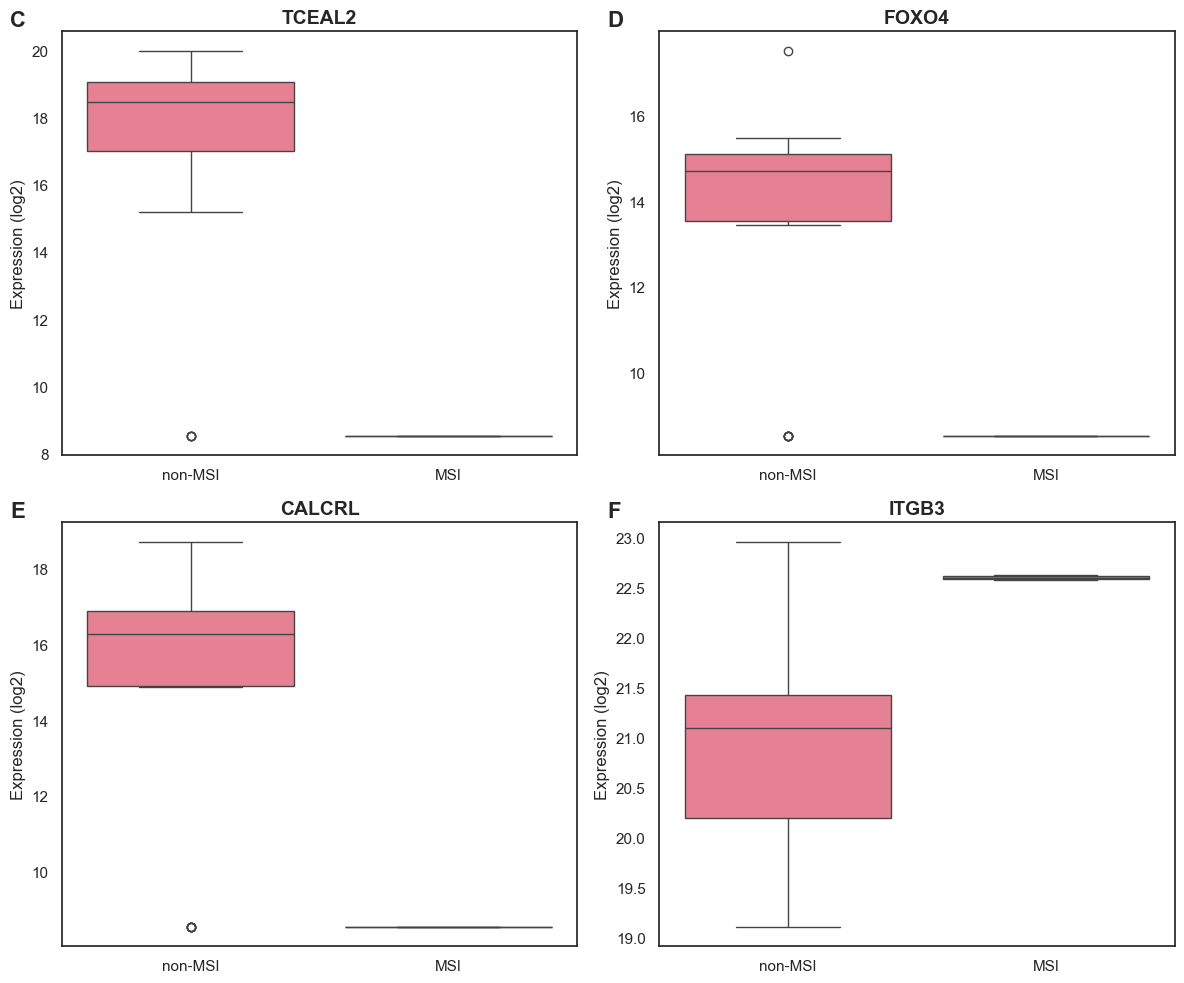

In [24]:
# Top-Gene für Plot
top_genes = ['TCEAL2', 'FOXO4', 'CALCRL', 'ITGB3']
labels_subplot = ['C', 'D', 'E', 'F']

# Reihenfolge für Boxplot (MSI-Kategorien)
msi_order = ['non-MSI', 'MSI']

# Figure erstellen
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, gene in enumerate(top_genes):
    ax = axes[i]
    
    sns.boxplot(
        x='MSI_binary',
        y=gene,
        data=meta_msi,
        order=msi_order,
        palette='husl',
        ax=ax
    )
    
    # Titel: Genname
    ax.set_title(gene, fontsize=14, fontweight='bold')
    
    # y-Achse Label
    ax.set_ylabel("Expression (log2)")
    
    # x-Achse Label entfernen
    ax.set_xlabel("")
    
    # Buchstabe oben links (außerhalb des Plot-Bereichs)
    ax.text(-0.1, 1.05, labels_subplot[i], transform=ax.transAxes,
            fontsize=16, fontweight='bold', va='top', ha='left')

# Layout anpassen, um nichts abzuschneiden
plt.tight_layout()
plt.show()

In [25]:
# für gprofiler (ich weiß dass es nicht wirklich signifikant
# ist wegen zu kleiner Gruppengrößen)

sig_msi_genes = results_msi.loc[results_msi['Significant'], 'Gene'].tolist()

# Als whitespace-separierte Zeichenkette
sig_gene_string = " ".join(sig_msi_genes)

print("\n Signifikante Gene (FDR < 0.05), whitespace-separated:\n")
print(sig_gene_string)


 Signifikante Gene (FDR < 0.05), whitespace-separated:

PSMD8 EPM2AIP1 GSK3B DHPS MAP1B RPS5 EPS15 MLH1 CSK NSF KDELC2 PTPN9 ATAD2 MLLT4 EXOC7 RAB5C LIG3 THSD4 ATF7IP DICER1 RAB11FIP1 SHOC2 MAP4K3 EIF2S2 IMPDH1 SIK3 DIABLO HOOK3 CAPG CPOX ERC1 EEF1D PPP2R1A CDC27 UQCRC1 STIP1 GATAD2A MTAP ROCK1 ADAM9 DPYSL2 FLII VPS33B STRN3 LRRFIP1 PTPN23 ETFDH NCAPH STXBP2 NELFA TRIP10 SF1 VPS26B SEPT9 TRPS1 HBB RPRD2 GNB2L1 PDE12 COPS3 CTBP2 LIMA1 RAB2A NUCB1 TMF1 PUF60 CLTC XPO7 TMX4 ADPRHL2 EFHD2 ISOC1 NCOA5 DNAJC7 FAF2 WFS1 SNCG VTI1A EXOSC8 PMPCB LAD1 SCAF11 SPAG7 CELF1 PSMD11 GPKOW SLU7 KIF13B ERGIC1 NCLN ISOC2 SBF1 CDKN2AIP TAF4 SNX5 DDX18 ADAM10 HSPA12A PLXNB2 TCERG1 NEMF FUBP3 PDLIM5 NUP88 FAM84B IDH3B DCHS1 KIF1C ADH5 CNP MOSPD2 INADL THOC2 LSM14A YBX3 IVNS1ABP UNK FNBP4 PRKCSH PRKAR2A DYNC2H1 APEH EZR JUP MAP3K4 ARFGEF1 IGHA1 IGKC GLUD1 PDLIM1 SNAP23 TERF2IP SSH1 ITGAV PFKM LYN FAM120A SLC4A2 ITGB3 PDCD6IP CORO1B PPP4R1 GPC1 WNT5A PLXND1 RPS3 CTSK CRTC1 ZFP91 MTMR10 PABPC4 PUM2 FAS RPL23 

In [26]:
# Nach FDR (oder p-Wert) sortieren
results_msi_sorted = results_msi.sort_values('FDR', ascending=True)

# Top 100 Gene auswählen
top100_genes = results_msi_sorted.head(100)['Gene'].tolist()
# Als whitespace-separierte Zeichenkette
top100_string = " ".join(top100_genes)

print(top100_string)

TCEAL2 NSF CSK FOXO4 CALCRL KIF13B ITGB3 FAM53C SH3GL2 ATF2 UQCRH UQCRHL PEAR1 IGHV3OR16-12 DTX3 CTSK RPS13 NUCB1 TSPAN13 PPP1R3G HSPA12A KDELC2 NOL3 FAM177A1 RPS16 BAHD1 INADL NDUFB4 MOSPD2 MLH1 SRSF7 QIL1 LAD1 EPM2AIP1 ADPRHL2 SNX5 RAB35 FAF2 IDH3B WFS1 ELF3 HSP90AB4P RPL30 DHPS MBNL1 NUP88 SLC35F6 C8orf59 UNK SCRN3 IGHA1 RPL37 RAB5C UQCRC1 MYDGF JUP ACD GSK3B MAP3K4 NAPB MRPL52 SLC1A3 VAMP5 APEH VPS26B PEX7 LYN CPA3 CRISPLD2 LIMA1 OPA3 TCEB1 CDC27 FAM188B S100A10 NCAPH LIN9 MAP1B EXOSC8 EIF2S2 ZFP91 GNB2L1 TCERG1 PABPC4 STRN3 PRKAR2A ADAM9 FLII SEPW1 MLLT4 PMM2 SNX33 UBE2T ISOC2 ERC1 GPKOW ITGAV FAM105A ZFYVE26 MT-ND1


### histologic grade (107 significant)

In [27]:
# ------------------------------------------------------
# Daten vorbereiten

df = proteomics_metadata.copy()
tumor_samples = df[df['Group'].str.strip() == 'Tumor'].copy()

# Nur G1, G2, G3 betrachten
grades_of_interest = ['G1 Well differentiated', 'G2 Moderately differentiated', 'G3 Poorly differentiated']
tumor_samples = tumor_samples[tumor_samples['histologic_grade'].isin(grades_of_interest)]

# ---------------------------
# Kontrollprints

print(f"Anzahl Tumorproben insgesamt: {tumor_samples.shape[0]}")
grade_counts = tumor_samples['histologic_grade'].value_counts()
print(" Anzahl Tumorproben pro histologic_grade:")
print(grade_counts)

# ------------------------------------------------------
# Expression columns (nur Gene, keine Meta-Spalten)

meta_cols = [
    'ParticipantID (Case_ID)', 'Group', 'age', 'BMI', 'tumor_stage_pathological',
    'tobacco_smoking_history', 'diabetes', 'histologic_type', 'histologic_grade',
    'microsatellite_instability', 'tumor_size_in_cm', 'number_of_full_term_pregnancies',
    'pathologic_staging_primary_tumor_pT', 'ParticipantID', 'TMT plex', 'TMT channel',
    'batch_ID', 'tissue_type'
]

expr_cols = [c for c in tumor_samples.select_dtypes(include=np.number).columns if c not in meta_cols]
print(f"Verwendete Gene: {len(expr_cols)}")  # sollte 9120 sein

# ------------------------------------------------------
# ANOVA pro Gen (histologic_grade)

results = []
genes_analyzed = 0

for gene in expr_cols:
    groups_list = [tumor_samples.loc[tumor_samples['histologic_grade'] == grade, gene].dropna().values
                   for grade in grades_of_interest]
    
    # Nur durchführen, wenn alle Gruppen mindestens 2 Proben haben
    if all(len(g) > 1 for g in groups_list):
        f_stat, p_val = f_oneway(*groups_list)
        results.append({'Gene': gene, 'F_stat': f_stat, 'p_value': p_val})
        genes_analyzed += 1

anova_df = pd.DataFrame(results)
print(f"Anzahl Gene, die für ANOVA ausgewertet wurden: {genes_analyzed}")

# ------------------------------------------------------
# FDR-Korrektur

anova_df['FDR'] = multipletests(anova_df['p_value'], method='fdr_bh')[1]

# Signifikante Gene
sig_genes = anova_df[anova_df['FDR'] < 0.05]
print(f"\n Signifikante Gene (FDR < 0.05) für histologic_grade Effekt: {len(sig_genes)}")
print("\nTop 15 signifikante Gene:")
print(sig_genes.sort_values('FDR').head(15))


Anzahl Tumorproben insgesamt: 92
 Anzahl Tumorproben pro histologic_grade:
histologic_grade
G2 Moderately differentiated    38
G1 Well differentiated          31
G3 Poorly differentiated        23
Name: count, dtype: int64
Verwendete Gene: 9120
Anzahl Gene, die für ANOVA ausgewertet wurden: 9120

 Signifikante Gene (FDR < 0.05) für histologic_grade Effekt: 107

Top 15 signifikante Gene:
         Gene     F_stat       p_value       FDR
129     STAT1  23.299703  7.284231e-09  0.000066
627      TYMP  17.902165  2.921702e-07  0.001022
4871    PALMD  17.304755  4.482769e-07  0.001022
3996     PLD3  17.331424  4.397533e-07  0.001022
3945      ADA  16.875739  6.111751e-07  0.001115
920      GBP1  16.562028  7.677170e-07  0.001167
2971    UCHL1  15.630429  1.521682e-06  0.001983
3558     MZB1  15.271758  1.985853e-06  0.002264
1608  PPP1R18  14.835715  2.750746e-06  0.002650
1496  THEMIS2  14.762479  2.906155e-06  0.002650
776    FERMT3  14.428572  3.736949e-06  0.003029
2198    IFIT3  14.3432

In [28]:
# Liste der signifikanten Gene
sig_gene_list = sig_genes['Gene'].tolist()
#print(len(sig_genes)) --> soll 107 sein
# Als durch Leerzeichen getrennte Zeichenkette (für Copy/Paste in g:Profiler)
gene_string = " ".join(sig_gene_list)
print(gene_string)

ARRB1 STAT1 ARHGAP25 GALNT7 WAS MKI67 KIF11 STAT2 BCAM BIN2 ARHGDIB SH2D4A CLIP2 USP11 WARS PTPN3 MX2 TYMP CMTR1 FERMT3 CAPG GBP1 GBP2 IFI16 PTBP2 ALDH1L2 ACSL5 PLCB1 GRB7 IL16 RNF213 THEMIS2 PPP1R18 NAGK EVL ARHGAP4 SPON1 RCN3 OPTN IGF2BP3 SH3KBP1 PAPLN INPP5D IFIT3 KIF13B GLS HGD GBP5 FNBP1 PSAT1 COG3 TOP2A GIMAP8 OGFR UCHL1 PLCG2 FAM169A TRIM2 COLGALT1 HCLS1 CAPN6 SH3BP1 APOE IGHG1 FGA GIMAP4 C9 FN1 DOCK2 SAMHD1 PGR FAM49B PLEK THBS1 MZB1 SMCHD1 ICAM1 AP1G2 ADA PLD3 VAV1 BDH2 ZGPAT C1QB IFIT2 TOM1L1 UBE2L6 FBXO2 UBE2C PARVB LCP2 GIMAP1 PALMD CSTA AGR3 GCHFR MED4 CTSA ALOX5 MTHFD2 CRLF3 RENBP SP110 FABP3 IGKV4-1 FXYD1 HLA-DMA


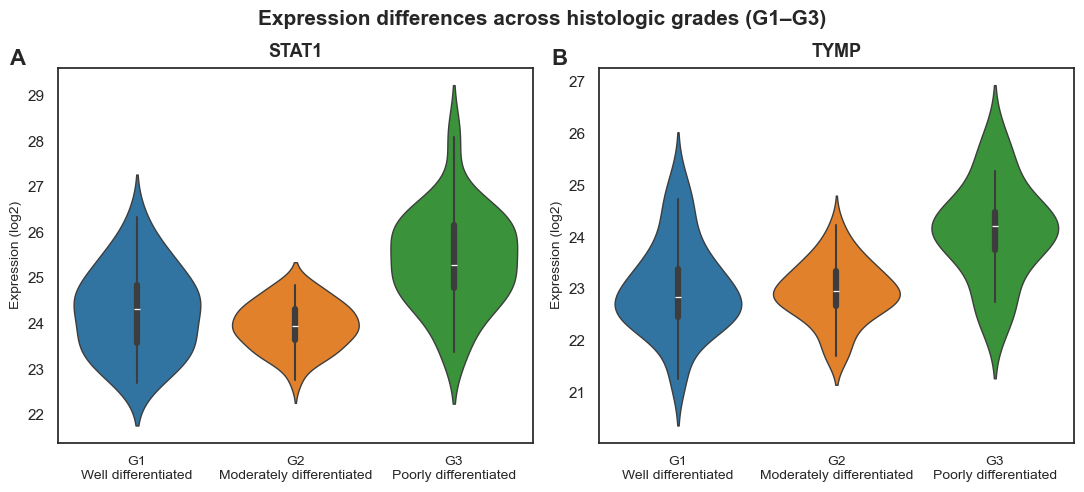

In [29]:
genes_to_plot = ['STAT1', 'TYMP']
subplot_labels = ['A', 'B']

grade_labels = {
    'G1 Well differentiated': 'G1\nWell differentiated',
    'G2 Moderately differentiated': 'G2\nModerately differentiated',
    'G3 Poorly differentiated': 'G3\nPoorly differentiated'
}
grade_order = ['G1 Well differentiated', 'G2 Moderately differentiated', 'G3 Poorly differentiated']

palette = sns.color_palette("tab10", n_colors=len(grade_order))
palette_dict = dict(zip(grade_order, palette))

fig, axes = plt.subplots(1, 2, figsize=(11, 5))
axes = axes.flatten()

for i, (gene, label) in enumerate(zip(genes_to_plot, subplot_labels)):
    ax = axes[i]
    sns.violinplot(
        x='histologic_grade', y=gene,
        data=tumor_samples,
        order=grade_order,
        hue='histologic_grade',
        palette=palette_dict,
        inner='box',
        legend=False,
        linewidth=1,
        ax=ax
    )

    ax.set_xticks(range(len(grade_order)))
    ax.set_xticklabels([grade_labels[g] for g in grade_order], fontsize=10)
    ax.set_title(gene, fontsize=13, fontweight='semibold', pad=8)
    ax.set_xlabel("")
    ax.set_ylabel("Expression (log2)", fontsize=10)

    ax.text(
        -0.1, 1.05, label,  # leicht außerhalb oben links
        transform=ax.transAxes,
        fontsize=16,
        fontweight='bold',
        va='top',
        ha='left'
    )

plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.suptitle("Expression differences across histologic grades (G1–G3)",
             fontsize=15, fontweight='bold')
plt.show()

#### subplot 2x2 mit 4 sig genes G1-G3

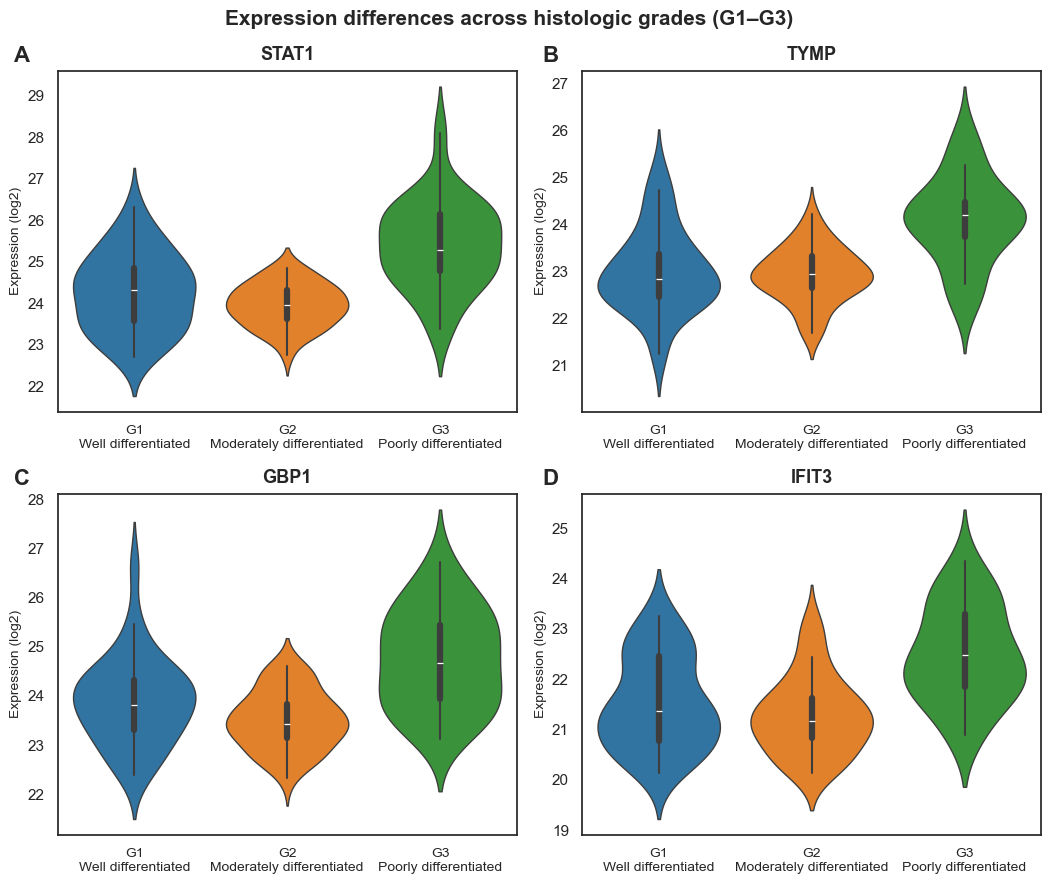

In [30]:
genes_to_plot = ['STAT1', 'TYMP', 'GBP1', 'IFIT3']
subplot_labels = ['A', 'B', 'C', 'D']

grade_labels = {
    'G1 Well differentiated': 'G1\nWell differentiated',
    'G2 Moderately differentiated': 'G2\nModerately differentiated',
    'G3 Poorly differentiated': 'G3\nPoorly differentiated'
}
grade_order = ['G1 Well differentiated', 'G2 Moderately differentiated', 'G3 Poorly differentiated']

palette = sns.color_palette("tab10", n_colors=len(grade_order))
palette_dict = dict(zip(grade_order, palette))

fig, axes = plt.subplots(2, 2, figsize=(11, 9))
axes = axes.flatten()

for i, (gene, label) in enumerate(zip(genes_to_plot, subplot_labels)):
    ax = axes[i]
    sns.violinplot(
        x='histologic_grade', y=gene,
        data=tumor_samples,
        order=grade_order,
        hue='histologic_grade',
        palette=palette_dict,
        inner='box',
        legend=False,
        linewidth=1,
        ax=ax
    )

    ax.set_xticks(range(len(grade_order)))
    ax.set_xticklabels([grade_labels[g] for g in grade_order], fontsize=10)
    ax.set_title(gene, fontsize=13, fontweight='semibold', pad=8)
    ax.set_xlabel("")
    ax.set_ylabel("Expression (log2)", fontsize=10)

    # Buchstaben außerhalb der Plots
    fig.text(
        0.05 + (i % 2) * 0.48,
        0.94 - (i // 2) * 0.47,
        label,
        fontsize=16,
        fontweight='bold',
        va='top',
        ha='left'
    )

plt.tight_layout(rect=[0.03, 0, 1, 0.96])
fig.suptitle("Expression differences across histologic grades (G1–G3)",
             fontsize=15, fontweight='bold')
plt.show()

### tobacco smoking history (0 significant)

In [31]:

# --- Datensatz kopieren ---
df = proteomics_metadata.copy()

# Nur Tumorproben
df_tumor = df[df['Group'].str.strip() == 'Tumor'].copy()

# --- Neue vereinfachte Kategorien ---
mapping = {
    'Lifelong non-smoker: Less than 100 cigarettes smoked in lifetime': 'Non-smoker',
    'Current smoker: Includes daily and non-daily smokers': 'Current smoker',
    'Current reformed smoker, more than 15 years': 'Former smoker',
    'Current reformed smoker within past 15 years': 'Former smoker',
    'Smoking history not available': 'Unknown'
}

df_tumor['Smoking_simplified'] = df_tumor['tobacco_smoking_history'].map(mapping)

# Nur relevante Gruppen behalten
df_tumor = df_tumor[df_tumor['Smoking_simplified'] != 'Unknown']

# Kontrolle
print("Anzahl Tumorproben pro Rauchkategorie:")
print(df_tumor['Smoking_simplified'].value_counts())

# --- Expression columns ---
expr_cols = df_tumor.select_dtypes(include=np.number).columns.tolist()
print(f"Verwendete Gene: {len(expr_cols)}")

# --- ANOVA ---
results = []
groups = ['Non-smoker', 'Former smoker', 'Current smoker']

for gene in expr_cols:
    sub = df_tumor[['Smoking_simplified', gene]].dropna()
    groups_list = [sub.loc[sub['Smoking_simplified'] == grp, gene].values for grp in groups]
    
    # Nur wenn jede Gruppe >= 2 Werte hat
    if all(len(g) > 1 for g in groups_list):
        f_stat, p_val = f_oneway(*groups_list)
        results.append({'Gene': gene, 'p_value': p_val})

anova_df = pd.DataFrame(results)

# --- FDR-Korrektur ---
anova_df['FDR'] = multipletests(anova_df['p_value'], method='fdr_bh')[1]
sig_genes = anova_df[anova_df['FDR'] < 0.05]

print(f"\n Signifikante Gene (FDR < 0.05) für Raucherstatus: {len(sig_genes)}")
print(sig_genes.head(10))

Anzahl Tumorproben pro Rauchkategorie:
Smoking_simplified
Non-smoker        69
Former smoker     15
Current smoker     7
Name: count, dtype: int64
Verwendete Gene: 9124

 Signifikante Gene (FDR < 0.05) für Raucherstatus: 0
Empty DataFrame
Columns: [Gene, p_value, FDR]
Index: []


### number of full-term pregnancies (0 significant)

In [32]:
counts = proteomics_metadata['number_of_full_term_pregnancies'].value_counts(dropna=False)
print(counts)

number_of_full_term_pregnancies
NaN          32
2            31
1            28
4 or more    19
Unknown      17
3            12
1.0           2
2.0           2
3.0           1
Name: count, dtype: int64


In [33]:
# ==== Nur Tumor-Proben auswählen ====
tumor_df = meta_no_nans[meta_no_nans["Group"].str.strip() == "Tumor"].copy()

# ==== Spalte number_of_full_term_pregnancies aufräumen ====
tumor_df = tumor_df.dropna(subset=["number_of_full_term_pregnancies"])
tumor_df = tumor_df[tumor_df["number_of_full_term_pregnancies"] != "Unknown"]

# Einheitliche Strings
tumor_df["number_of_full_term_pregnancies"] = tumor_df["number_of_full_term_pregnancies"].astype(str).str.strip()

# ==== Neue Kategorien ====
def categorize_preg(x):
    if x == "None":
        return "None"
    elif x in ["1", "1.0"]:
        return "1"
    elif x in ["2", "2.0"]:
        return "2"
    elif x in ["3", "3.0", "4", "4.0", "4 or more", "5", "5.0"]:
        return "3 or more"
    else:
        return np.nan  # falls ein unerwarteter Wert vorkommt

tumor_df["pregnancy_category"] = tumor_df["number_of_full_term_pregnancies"].apply(categorize_preg)

# NaN raus
tumor_df = tumor_df.dropna(subset=["pregnancy_category"])

# ==== Gruppengrößen ausgeben ====
print("\nGruppengrößen nach neuer Kategorisierung:")
print(tumor_df["pregnancy_category"].value_counts().sort_index())

# ==== Gruppennamen definieren (neu aus pregnancy_category) ====
preg_groups = tumor_df["pregnancy_category"].unique()
print("\nVerwendete Gruppen für ANOVA:", preg_groups)

# ==== Genexpressionsspalten definieren ====
non_gene_cols = [
    'ParticipantID (Case_ID)', 'Group', 'age', 'BMI', 'tumor_stage_pathological',
    'tobacco_smoking_history', 'diabetes', 'histologic_type', 'histologic_grade',
    'microsatellite_instability', 'tumor_size_in_cm', 'number_of_full_term_pregnancies',
    'pathologic_staging_primary_tumor_pT', 'ParticipantID', 'TMT plex',
    'TMT channel', 'batch_ID', 'tissue_type', 'pregnancy_category'
]

gene_cols = [col for col in tumor_df.columns if col not in non_gene_cols]
print(f"Anzahl potenzieller Gen-Spalten: {len(gene_cols)}")

# ==== ANOVA durchführen ====
p_values = []
valid_genes = []

for gene in gene_cols:
    # sicherstellen, dass es numerische Werte sind
    try:
        tumor_df[gene] = pd.to_numeric(tumor_df[gene], errors='coerce')
    except Exception:
        continue

    # Gruppen bilden basierend auf pregnancy_category
    groups = [
        tumor_df.loc[tumor_df["pregnancy_category"] == g, gene].dropna()
        for g in preg_groups
        if len(tumor_df.loc[tumor_df["pregnancy_category"] == g, gene].dropna()) > 1
    ]

    # nur wenn mindestens 2 Gruppen mit Werten existieren
    if len(groups) > 1:
        f_stat, p_val = f_oneway(*groups)
        p_values.append(p_val)
        valid_genes.append(gene)

# ==== Prüfen, ob Tests durchgeführt wurden ====
if len(p_values) == 0:
    print("\nKeine gültigen ANOVA-Tests durchgeführt. Wahrscheinlich zu wenige Werte pro Gruppe.")
    sig_preg = []
else:
    # ==== Mehrfachtestkorrektur (FDR 0.05) ====
    p_values = np.array(p_values, dtype=float)
    reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

    # ==== Signifikante Gene extrahieren ====
    sig_genes = np.array(valid_genes)[reject]
    sig_preg = list(sig_genes)

    print(f"\nAnzahl signifikanter Gene (FDR 0.05): {len(sig_preg)}")
    if len(sig_preg) > 0:
        print("Beispiele:", sig_preg[:20])


Gruppengrößen nach neuer Kategorisierung:
pregnancy_category
1            22
2            27
3 or more    22
Name: count, dtype: int64

Verwendete Gruppen für ANOVA: ['2' '3 or more' '1']
Anzahl potenzieller Gen-Spalten: 9120

Anzahl signifikanter Gene (FDR 0.05): 0


### pathologic_staging_primary_tumor_pT (0 significant)

In [34]:
counts = proteomics_metadata['pathologic_staging_primary_tumor_pT'].value_counts(dropna=False)
print(counts)

pathologic_staging_primary_tumor_pT
pT1a (FIGO IA)      76
pT1b (FIGO IB)      22
NaN                 19
pT2 (FIGO II)       14
pT3a (FIGO IIIA)     8
pT3b (FIGO IIIB)     4
pT1 (FIGO I)         1
Name: count, dtype: int64


In [35]:
# Nur Einträge mit "Tumor " (mit Leerzeichen) auswählen
tumor_space_df = proteomics_metadata[proteomics_metadata["Group"] == "Tumor "]

# Zählen, wie viele pro pT-Kategorie vorhanden sind
pt_counts_tumor_space = tumor_space_df["pathologic_staging_primary_tumor_pT"].value_counts(dropna=False)

print("Anzahl der Fälle pro pathologic_staging_primary_tumor_pT (nur Group == 'Tumor '):")
print(pt_counts_tumor_space)


Anzahl der Fälle pro pathologic_staging_primary_tumor_pT (nur Group == 'Tumor '):
Series([], Name: count, dtype: int64)


In [36]:
# ==== 1. Nur Tumor-Proben auswählen ====
tumor_df = meta_no_nans[meta_no_nans["Group"].str.strip() == "Tumor"].copy()

# ==== 2. pT-Stadien zu biologisch sinnvollen Gruppen zusammenfassen ====
def simplify_pT(x):
    if x in ["pT1 (FIGO I)", "pT1a (FIGO IA)", "pT1b (FIGO IB)"]:
        return "Early (pT1)"
    elif x in ["pT2 (FIGO II)"]:
        return "Intermediate (pT2)"
    elif x in ["pT3a (FIGO IIIA)", "pT3b (FIGO IIIB)"]:
        return "Advanced (pT3)"
    else:
        return np.nan

tumor_df["pT_grouped"] = tumor_df["pathologic_staging_primary_tumor_pT"].apply(simplify_pT)

# ==== 3. Gruppen prüfen ====
print("\nGruppengrößen nach pT-Zusammenfassung:")
print(tumor_df["pT_grouped"].value_counts().sort_index())

# ==== 4. Genexpressionsspalten definieren ====
non_gene_cols = [
    'ParticipantID (Case_ID)', 'Group', 'age', 'BMI', 'tumor_stage_pathological',
    'tobacco_smoking_history', 'diabetes', 'histologic_type', 'histologic_grade',
    'microsatellite_instability', 'tumor_size_in_cm', 'number_of_full_term_pregnancies',
    'pathologic_staging_primary_tumor_pT', 'ParticipantID', 'TMT plex', 
    'TMT channel', 'batch_ID', 'tissue_type', 'pT_grouped'
]

gene_cols = [col for col in tumor_df.columns if col not in non_gene_cols]
print(f"\nAnzahl potenzieller Gen-Spalten: {len(gene_cols)}")

# ==== 5. --- (A) ANOVA: Early vs Intermediate vs Advanced ====
anova_pvals = []
anova_genes = []

groups_3 = ["Early (pT1)", "Intermediate (pT2)", "Advanced (pT3)"]

for gene in gene_cols:
    try:
        tumor_df[gene] = pd.to_numeric(tumor_df[gene], errors="coerce")
    except Exception:
        continue
    
    data_groups = [
        tumor_df.loc[tumor_df["pT_grouped"] == g, gene].dropna()
        for g in groups_3 if len(tumor_df.loc[tumor_df["pT_grouped"] == g, gene].dropna()) > 1
    ]
    
    if len(data_groups) > 1:
        f_stat, p_val = f_oneway(*data_groups)
        anova_pvals.append(p_val)
        anova_genes.append(gene)

# FDR-Korrektur für ANOVA
anova_pvals = np.array(anova_pvals, dtype=float)
reject_a, pvals_corr_a, _, _ = multipletests(anova_pvals, alpha=0.05, method="fdr_bh")

sig_genes_anova = np.array(anova_genes)[reject_a]
sig_pt_anova = list(sig_genes_anova)

print(f"\n ANOVA (Early vs Intermediate vs Advanced): {len(sig_pt_anova)} signifikante Gene (FDR 0.05)")
if len(sig_pt_anova) > 0:
    print("Beispiele:", sig_pt_anova[:20])


# ==== 6. --- (B) t-Test: Early vs Advanced ====
ttest_pvals = []
ttest_genes = []

group_early = tumor_df[tumor_df["pT_grouped"] == "Early (pT1)"]
group_adv   = tumor_df[tumor_df["pT_grouped"] == "Advanced (pT3)"]

for gene in gene_cols:
    x = pd.to_numeric(group_early[gene], errors="coerce").dropna()
    y = pd.to_numeric(group_adv[gene], errors="coerce").dropna()
    if len(x) > 1 and len(y) > 1:
        stat, p_val = ttest_ind(x, y, equal_var=False)
        ttest_pvals.append(p_val)
        ttest_genes.append(gene)

# FDR-Korrektur für t-Test
ttest_pvals = np.array(ttest_pvals, dtype=float)
reject_t, pvals_corr_t, _, _ = multipletests(ttest_pvals, alpha=0.05, method="fdr_bh")

sig_genes_ttest = np.array(ttest_genes)[reject_t]
sig_pt_ttest = list(sig_genes_ttest)

print(f"\n t-Test (Early vs Advanced): {len(sig_pt_ttest)} signifikante Gene (FDR 0.05)")
if len(sig_pt_ttest) > 0:
    print("Beispiele:", sig_pt_ttest[:20])



Gruppengrößen nach pT-Zusammenfassung:
pT_grouped
Advanced (pT3)        10
Early (pT1)           74
Intermediate (pT2)    11
Name: count, dtype: int64

Anzahl potenzieller Gen-Spalten: 9120

 ANOVA (Early vs Intermediate vs Advanced): 0 signifikante Gene (FDR 0.05)

 t-Test (Early vs Advanced): 11 signifikante Gene (FDR 0.05)
Beispiele: [np.str_('IGKV2-24'), np.str_('IGKV2D-24'), np.str_('FCN3'), np.str_('GRHL1'), np.str_('ZNF414'), np.str_('OBFC1'), np.str_('ETS1'), np.str_('DCAF15'), np.str_('CTDSP1'), np.str_('SH3BP5'), np.str_('SREK1IP1')]


In [37]:

# Gruppe 1: pT1a (FIGO IA)
group_pT1a = tumor_df[tumor_df["pathologic_staging_primary_tumor_pT"] == "pT1a (FIGO IA)"]

# Gruppe 2: alle anderen Tumoren
group_rest = tumor_df[tumor_df["pathologic_staging_primary_tumor_pT"] != "pT1a (FIGO IA)"]

ttest_pvals_pT1a = []
ttest_genes_pT1a = []

for gene in gene_cols:
    x = pd.to_numeric(group_pT1a[gene], errors="coerce").dropna()
    y = pd.to_numeric(group_rest[gene], errors="coerce").dropna()
    
    if len(x) > 1 and len(y) > 1:
        stat, p_val = ttest_ind(x, y, equal_var=False)
        ttest_pvals_pT1a.append(p_val)
        ttest_genes_pT1a.append(gene)

# FDR-Korrektur
ttest_pvals_pT1a = np.array(ttest_pvals_pT1a, dtype=float)
reject_pT1a, pvals_corr_pT1a, _, _ = multipletests(ttest_pvals_pT1a, alpha=0.05, method='fdr_bh')

sig_genes_pT1a = np.array(ttest_genes_pT1a)[reject_pT1a]
sig_genes_pT1a_list = list(sig_genes_pT1a)

print(f"\n t-Test (pT1a vs Rest): {len(sig_genes_pT1a_list)} signifikante Gene (FDR 0.05)")
if len(sig_genes_pT1a_list) > 0:
    print("Beispiele:", sig_genes_pT1a_list[:20])



 t-Test (pT1a vs Rest): 0 signifikante Gene (FDR 0.05)


### tumor size (0 significant)

In [38]:
# Nur Tumor-Proben
tumor_df = proteomics_metadata[proteomics_metadata["Group"].str.strip() == "Tumor"].copy()

# Spalte bereinigen: < oder > entfernen, Komma als Dezimalpunkt ersetzen, in float umwandeln
def clean_size(x):
    try:
        x = str(x).replace("<", "").replace(">", "").replace(",", ".").strip()
        return float(x)
    except:
        return np.nan

tumor_df["tumor_size_in_cm_numeric"] = tumor_df["tumor_size_in_cm"].apply(clean_size)

# Häufigkeitstabelle für Tumorgröße
size_counts = tumor_df["tumor_size_in_cm_numeric"].value_counts(dropna=False).sort_index()

print("Häufigkeitstabelle Tumorgröße (cm):")
print(size_counts)



Häufigkeitstabelle Tumorgröße (cm):
tumor_size_in_cm_numeric
0.8     1
0.9     1
1.0     6
1.2     1
1.3     3
1.4     2
1.5     4
1.7     1
1.8     1
2.2     2
2.3     4
2.5     3
2.6     2
2.7     3
2.9     1
3.0     8
3.2     2
3.5     6
3.7     1
3.8     1
3.9     1
4.0     8
4.2     1
4.3     2
4.5     8
4.7     1
5.0     5
5.2     1
5.5     2
6.0     3
6.3     1
6.5     1
7.0     2
8.0     1
8.5     1
9.0     1
11.0    1
13.5    1
NaN     1
Name: count, dtype: int64


In [39]:
# Tumorgrößen-Gruppierung (Version 2)
def categorize_size_v2(x):
    if pd.isna(x):
        return np.nan
    elif x <= 2:
        return "small (≤2cm)"
    elif x <= 4:
        return "medium (2–4cm)"
    else:
        return "large (>4cm)"

tumor_df["tumor_size_group_v2"] = tumor_df["tumor_size_in_cm_numeric"].apply(categorize_size_v2)

# Gruppengrößen ausgeben
print("\nGruppengrößen Tumorgröße Version 2:")
print(tumor_df["tumor_size_group_v2"].value_counts().sort_index())




Gruppengrößen Tumorgröße Version 2:
tumor_size_group_v2
large (>4cm)      32
medium (2–4cm)    42
small (≤2cm)      20
Name: count, dtype: int64


In [41]:

# Gruppennamen für ANOVA
size_groups = ["small (≤2cm)", "medium (2–4cm)", "large (>4cm)"]

# ANOVA durchführen
p_values_size = []
valid_genes_size = []

for gene in gene_cols:
    # sicherstellen, dass Genwerte numerisch sind
    tumor_df[gene] = pd.to_numeric(tumor_df[gene], errors="coerce")
    
    # Werte für jede Tumorgröße sammeln
    data_groups = [
        tumor_df.loc[tumor_df["tumor_size_group_v2"] == g, gene].dropna()
        for g in size_groups
        if len(tumor_df.loc[tumor_df["tumor_size_group_v2"] == g, gene].dropna()) > 1
    ]
    
    # Nur durchführen, wenn mehr als eine Gruppe Werte hat
    if len(data_groups) > 1:
        f_stat, p_val = f_oneway(*data_groups)
        p_values_size.append(p_val)
        valid_genes_size.append(gene)

# Prüfen, ob Tests durchgeführt wurden
if len(p_values_size) == 0:
    print(" Keine gültigen ANOVA-Tests durchgeführt. Wahrscheinlich zu wenige Werte pro Gruppe.")
    sig_genes_size = []
else:
    # FDR-Korrektur
    p_values_size = np.array(p_values_size, dtype=float)
    reject, pvals_corrected, _, _ = multipletests(p_values_size, alpha=0.05, method='fdr_bh')

    # Signifikante Gene extrahieren
    sig_genes_size = np.array(valid_genes_size)[reject]
    sig_genes_size_list = list(sig_genes_size)

    print(f"\n ANOVA Tumorgröße (small vs medium vs large): {len(sig_genes_size_list)} signifikante Gene (FDR 0.05)")
    if len(sig_genes_size_list) > 0:
        print("Beispiele:", sig_genes_size_list[:20])




 ANOVA Tumorgröße (small vs medium vs large): 0 signifikante Gene (FDR 0.05)
